In [3]:
# Imports

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score,
    precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    classification_report, confusion_matrix,
    roc_curve, auc,
    hamming_loss
)

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler

from imblearn.under_sampling import RandomUnderSampler

import xgboost as xgb

RANDOM_STATE = 42

In [4]:
# Lecture du jeu de données

data_i = pd.read_csv("donnees-defi-egc.csv", sep=",", low_memory=False)
print("Shape:", data_i.shape)
display(data_i.head())

Shape: (15375, 34)


,ADR_SECTEUR,ANNEEDEPLANTATION,ANNEEREALISATIONDIAGNOSTIC,ANNEETRAVAUXPRECONISESDIAG,CODE,CODE_PARENT,CODE_PARENT_DESC,DIAMETREARBREAUNMETRE,ESPECE,FREQUENTATIONCIBLE,...,TYPEIMPLANTATIONPLU,VARIETE,VIGUEUR,coord_x,coord_y,DEFAUT,Collet,Houppier,Racine,Tronc
0,5,2014,2014,2019,ESP33155,ESP385,R D Fontanelle ang Essen JO,10 à 20 cm,cordata,passages fréquents ou arrêts,...,?,?,vigoureux,1.915371e+06,4.222837e+06,0,0,0,0,0
1,3,2004,2013,?,ESP2079,ESP116,Crs Libération Beauvert Alliés,30 à 40 cm,acerifolia,passages fréquents et arrêts fréquents,...,?,?,vigoureux,1.913250e+06,4.222531e+06,0,0,0,0,0
2,3,2004,?,2014,ESP26205,ESP635,Pl R Frappat ang Eaux Claires,10 à 20 cm,grandiflora,passages fréquents ou arrêts,...,?,?,vigoureux,1.913087e+06,4.223524e+06,0,0,0,0,0
3,2,2004,2014,2014,ESP7496,ESP109,R François Raoult,40 à 50 cm,japonica,passages fréquents et arrêts fréquents,...,?,?,vigoureux,1.914187e+06,4.224275e+06,1,0,1,1,0
4,1,2004,2013,?,ESP2547,ESP194,Terminus Tram Esclangon,20 à 30 cm,americana,passages fréquents et arrêts fréquents,...,?,?,vigoureux,1.912975e+06,4.225210e+06,0,0,0,0,0


In [6]:
data_i[["coord_x","coord_y"]].describe()

,coord_x,coord_y
count,1.537500e+04,1.537500e+04
mean,1.914222e+06,4.223314e+06
std,1.001492e+03,1.319505e+03
min,1.911907e+06,4.220467e+06
25%,1.913352e+06,4.222201e+06
50%,1.914340e+06,4.223104e+06
75%,1.915048e+06,4.224558e+06
max,1.916252e+06,4.226534e+06


# Analyse exploratoire - Prétraitements

In [3]:
# Remplacer '?' par NaN + supprimer colonnes "quasi identifiants"

data_i = data_i.replace("?", np.nan)

data = data_i.drop(columns=[c for c in ['CODE', 'CODE_PARENT', 'CODE_PARENT_DESC', 'SOUS_CATEGORIE'] if c in data_i.columns])

print("Shape après drop cols:", data.shape)
display(data.head())

Shape après drop cols: (15375, 30)


,ADR_SECTEUR,ANNEEDEPLANTATION,ANNEEREALISATIONDIAGNOSTIC,ANNEETRAVAUXPRECONISESDIAG,DIAMETREARBREAUNMETRE,ESPECE,FREQUENTATIONCIBLE,GENRE_BOTA,IDENTIFIANTPLU,INTITULEPROTECTIONPLU,...,TYPEIMPLANTATIONPLU,VARIETE,VIGUEUR,coord_x,coord_y,DEFAUT,Collet,Houppier,Racine,Tronc
0,5,2014,2014,2019,10 à 20 cm,cordata,passages fréquents ou arrêts,Alnus,NaN,NaN,...,NaN,NaN,vigoureux,1.915371e+06,4.222837e+06,0,0,0,0,0
1,3,2004,2013,NaN,30 à 40 cm,acerifolia,passages fréquents et arrêts fréquents,Platanus,NaN,NaN,...,NaN,NaN,vigoureux,1.913250e+06,4.222531e+06,0,0,0,0,0
2,3,2004,NaN,2014,10 à 20 cm,grandiflora,passages fréquents ou arrêts,Magnolia,NaN,NaN,...,NaN,NaN,vigoureux,1.913087e+06,4.223524e+06,0,0,0,0,0
3,2,2004,2014,2014,40 à 50 cm,japonica,passages fréquents et arrêts fréquents,Sophora,NaN,NaN,...,NaN,NaN,vigoureux,1.914187e+06,4.224275e+06,1,0,1,1,0
4,1,2004,2013,NaN,20 à 30 cm,americana,passages fréquents et arrêts fréquents,Fraxinus,NaN,NaN,...,NaN,NaN,vigoureux,1.912975e+06,4.225210e+06,0,0,0,0,0


In [5]:
# Listes num/cat + valeurs manquantes 

colonnes_numeriques = [c for c in data.columns if pd.api.types.is_numeric_dtype(data[c])]
colonnes_nominales = [c for c in data.columns if c not in colonnes_numeriques]

valeurs_manquantes = data.isnull().sum().sort_values(ascending=False)
pourcentage_manquant_par_colonne = (data.isnull().mean() * 100).round(2).sort_values(ascending=False)

print("Top colonnes manquantes:")
display(pd.DataFrame({
    "missing_count": valeurs_manquantes,
    "missing_%": pourcentage_manquant_par_colonne
}).head(20))

Top colonnes manquantes:


,missing_count,missing_%
RAISONDEPLANTATION,15145,98.50
INTITULEPROTECTIONPLU,15014,97.65
IDENTIFIANTPLU,15014,97.65
TYPEIMPLANTATIONPLU,15014,97.65
TRAITEMENTCHENILLES,14287,92.92
VARIETE,13212,85.93
REMARQUES,11176,72.69
TRAVAUXPRECONISESDIAG,4525,29.43
ANNEETRAVAUXPRECONISESDIAG,4511,29.34
ESPECE,1018,6.62


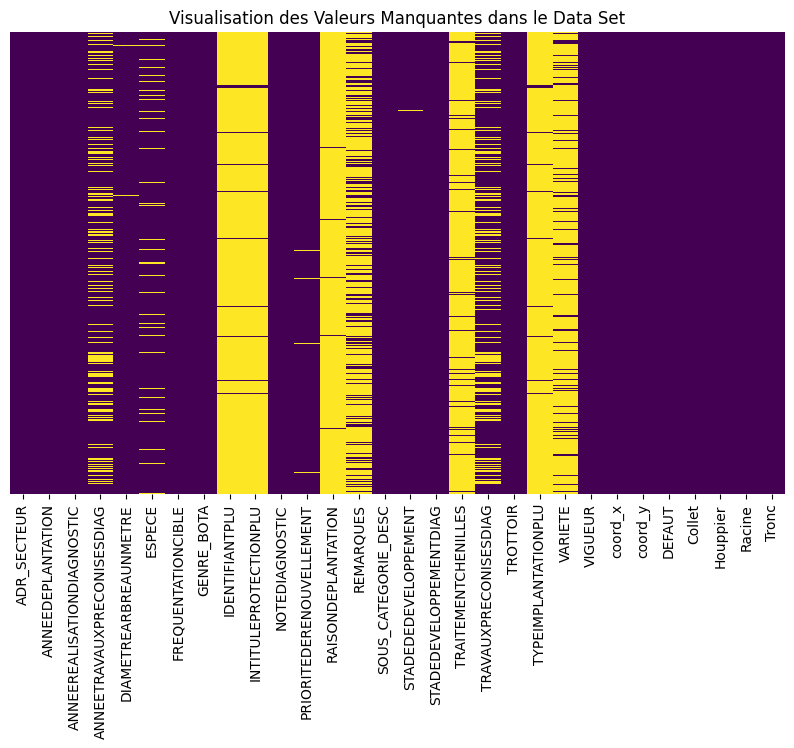

In [6]:
# Cellule 5 — Heatmap NA

plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title('Visualisation des Valeurs Manquantes dans le Data Set')
plt.show()

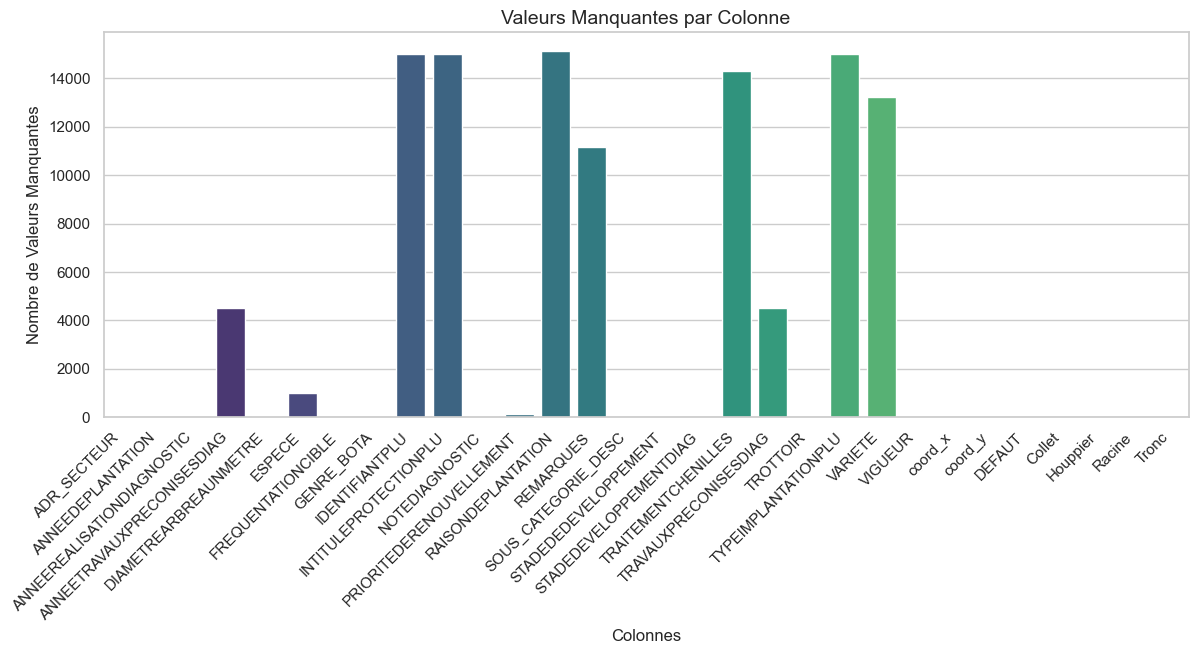

In [7]:
# Barplot NA 
valeurs_manquantes = data.isnull().sum()

sns.set(style='whitegrid')
plt.figure(figsize=(14, 5))
sns.barplot(x=valeurs_manquantes.index, y=valeurs_manquantes, palette='viridis')
plt.title('Valeurs Manquantes par Colonne', fontsize=14)
plt.xlabel('Colonnes', fontsize=12)
plt.ylabel('Nombre de Valeurs Manquantes', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

In [8]:
# Supprimer colonnes >70% NA 

seuil_pourcentage = 70
seuil = len(data) * seuil_pourcentage / 100.0

data_new = data.dropna(axis=1, thresh=seuil)

print("Shape après suppression >70% NA:", data_new.shape)
display(data_new.head())
display(data_new.describe(include="all").T.head(20))

Shape après suppression >70% NA: (15375, 23)


,ADR_SECTEUR,ANNEEDEPLANTATION,ANNEEREALISATIONDIAGNOSTIC,ANNEETRAVAUXPRECONISESDIAG,DIAMETREARBREAUNMETRE,ESPECE,FREQUENTATIONCIBLE,GENRE_BOTA,NOTEDIAGNOSTIC,PRIORITEDERENOUVELLEMENT,...,TRAVAUXPRECONISESDIAG,TROTTOIR,VIGUEUR,coord_x,coord_y,DEFAUT,Collet,Houppier,Racine,Tronc
0,5,2014,2014,2019,10 à 20 cm,cordata,passages fréquents ou arrêts,Alnus,Arbre davenir normal,plus de 20 ans,...,Controle,non,vigoureux,1.915371e+06,4.222837e+06,0,0,0,0,0
1,3,2004,2013,NaN,30 à 40 cm,acerifolia,passages fréquents et arrêts fréquents,Platanus,Arbre davenir normal,plus de 20 ans,...,NaN,non,vigoureux,1.913250e+06,4.222531e+06,0,0,0,0,0
2,3,2004,NaN,2014,10 à 20 cm,grandiflora,passages fréquents ou arrêts,Magnolia,Arbre davenir normal,plus de 20 ans,...,Controle,oui,vigoureux,1.913087e+06,4.223524e+06,0,0,0,0,0
3,2,2004,2014,2014,40 à 50 cm,japonica,passages fréquents et arrêts fréquents,Sophora,Arbre davenir normal,plus de 20 ans,...,Taille mise en sécurité,oui,vigoureux,1.914187e+06,4.224275e+06,1,0,1,1,0
4,1,2004,2013,NaN,20 à 30 cm,americana,passages fréquents et arrêts fréquents,Fraxinus,Arbre davenir normal,plus de 20 ans,...,NaN,oui,vigoureux,1.912975e+06,4.225210e+06,0,0,0,0,0


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ADR_SECTEUR,15375.0,NaN,NaN,NaN,3.680455,1.678015,1.0,2.0,4.0,5.0,6.0
ANNEEDEPLANTATION,15375.0,NaN,NaN,NaN,2004.92761,2.604701,2004.0,2004.0,2004.0,2004.0,2015.0
ANNEEREALISATIONDIAGNOSTIC,15367,5,2015,6634,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ANNEETRAVAUXPRECONISESDIAG,10864,11,2014,2217,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DIAMETREARBREAUNMETRE,15308,19,10 à 20 cm,4221,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ESPECE,14357,226,acerifolia,2864,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FREQUENTATIONCIBLE,15374,3,passages fréquents et arrêts fréquents,12164,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GENRE_BOTA,15375,107,Platanus,2982,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NOTEDIAGNOSTIC,15335,5,Arbre davenir normal,11716,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PRIORITEDERENOUVELLEMENT,15248,4,plus de 20 ans,11371,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Une colonne avec >70% de valeurs manquantes contient très peu d’info exploitable : elle va surtout rajouter du bruit, et l’imputation deviendrait essentiellement du “remplissage au hasard”. À l’inverse, une colonne avec par ex. 10–40% de NA peut être très informative : on préfère la garder et imputer (médiane/mode, etc.).

#### on enlève les colonnes presque vides, mais on garde celles qui ont encore assez de signal.

In [9]:
#  Imputation "exploratoire" (pour EDA seulement)

data_numerique = data_new.select_dtypes(include='number')
data_catégorielles = data_new.select_dtypes(include='object')

data_numerique = data_numerique.apply(lambda col: col.fillna(col.mean()), axis=0)

if len(data_catégorielles.columns) > 0:
    data_catégorielles = data_catégorielles.fillna(data_catégorielles.mode().iloc[0])

print("NA numériques:", data_numerique.isnull().sum().sum())
print("NA catégorielles:", data_catégorielles.isnull().sum().sum() if len(data_catégorielles.columns) else 0)

NA numériques: 0
NA catégorielles: 0


In [10]:
# Label Encoding (comme ton notebook) - pour EDA / corr seulement

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

for col in data_catégorielles.columns:
    data_catégorielles[col] = label_encoder.fit_transform(data_catégorielles[col].astype(str))

resultat = pd.concat([data_numerique, data_catégorielles], axis=1)
print("Shape resultat:", resultat.shape)
display(resultat.head())

Shape resultat: (15375, 23)


,ADR_SECTEUR,ANNEEDEPLANTATION,coord_x,coord_y,DEFAUT,Collet,Houppier,Racine,Tronc,ANNEEREALISATIONDIAGNOSTIC,...,FREQUENTATIONCIBLE,GENRE_BOTA,NOTEDIAGNOSTIC,PRIORITEDERENOUVELLEMENT,SOUS_CATEGORIE_DESC,STADEDEDEVELOPPEMENT,STADEDEVELOPPEMENTDIAG,TRAVAUXPRECONISESDIAG,TROTTOIR,VIGUEUR
0,5,2014,1.915371e+06,4.222837e+06,0,0,0,0,0,3,...,1,5,1,3,0,1,1,3,0,1
1,3,2004,1.913250e+06,4.222531e+06,0,0,0,0,0,2,...,0,75,1,3,0,0,0,12,0,1
2,3,2004,1.913087e+06,4.223524e+06,0,0,0,0,0,4,...,1,59,1,3,2,0,0,3,1,1
3,2,2004,1.914187e+06,4.224275e+06,1,0,1,1,0,3,...,0,94,1,3,0,0,0,13,1,1
4,1,2004,1.912975e+06,4.225210e+06,0,0,0,0,0,2,...,0,41,1,3,0,0,0,12,1,1


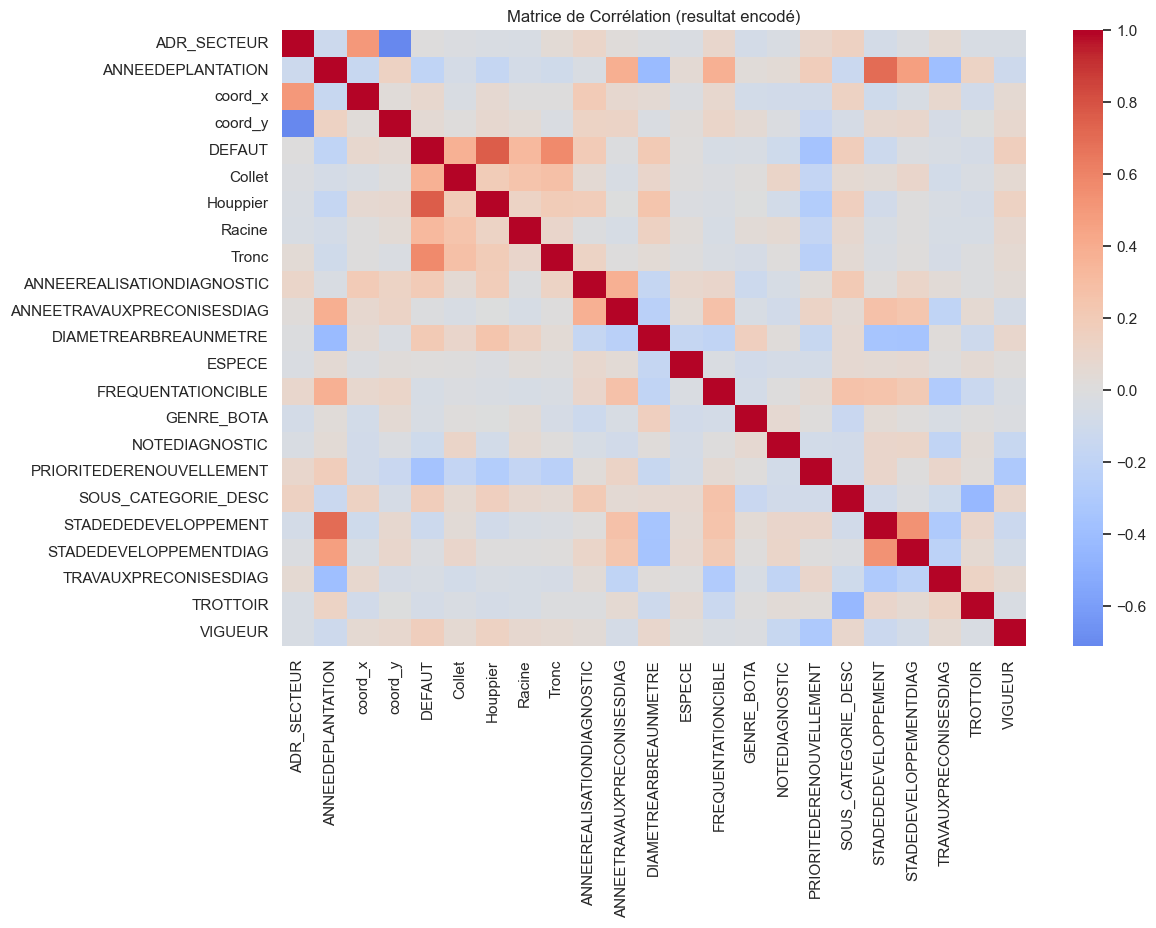

In [ ]:
# Matrice de corrélations

matrice_corr2 = resultat.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(matrice_corr2, cmap='coolwarm', center=0)
plt.title("Matrice de Corrélation (resultat encodé)")
plt.show()


# DÉFI 1 — Tâche 1 : UNI-LABEL (DEFAUT)

In [12]:
# X/y 

TARGETS = ['DEFAUT', 'Collet', 'Houppier', 'Racine', 'Tronc']
targets_present = [t for t in TARGETS if t in data_new.columns]
print("Cibles présentes:", targets_present)

assert 'DEFAUT' in data_new.columns, "Colonne DEFAUT absente."

X_raw = data_new.drop(columns=[t for t in TARGETS if t in data_new.columns])
y_defaut = data_new['DEFAUT'].astype(int)

print("X_raw:", X_raw.shape, "y_defaut:", y_defaut.shape)
print("Distribution DEFAUT:\n", y_defaut.value_counts(normalize=True).round(4))

Cibles présentes: ['DEFAUT', 'Collet', 'Houppier', 'Racine', 'Tronc']
X_raw: (15375, 18) y_defaut: (15375,)
Distribution DEFAUT:
 DEFAUT
0    0.6747
1    0.3253
Name: proportion, dtype: float64


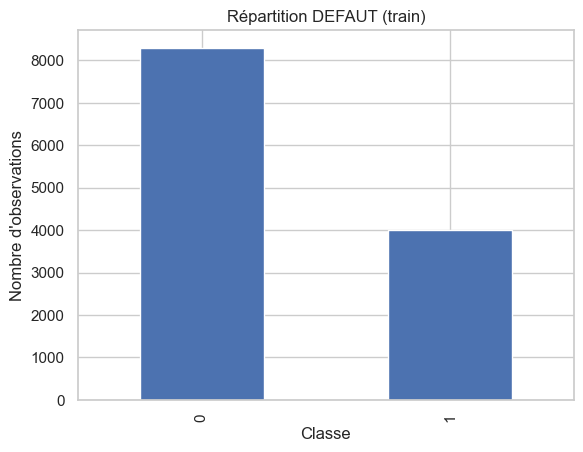

In [13]:
#Split stratifié  + barplot 

X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y_defaut, test_size=0.2, random_state=RANDOM_STATE, stratify=y_defaut
)

y_train.value_counts().plot(kind='bar')
plt.title('Répartition DEFAUT (train)')
plt.xlabel('Classe')
plt.ylabel("Nombre d'observations")
plt.show()

In [14]:
# Prétraitements 
# - OrdinalEncoder pour arbres/RF/XGB
# - OneHot pour LogisticRegression

num_cols = [c for c in X_raw.columns if pd.api.types.is_numeric_dtype(X_raw[c])]
cat_cols = [c for c in X_raw.columns if c not in num_cols]
print("Num:", len(num_cols), "Cat:", len(cat_cols))

preprocess_ordinal = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("enc", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
        ]), cat_cols),
    ],
    remainder="drop"
)

try:
    ohe = OneHotEncoder(handle_unknown="ignore", min_frequency=10, sparse_output=True)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore")

preprocess_onehot = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", ohe)
        ]), cat_cols),
    ],
    remainder="drop"
)

Num: 4 Cat: 14


In [16]:
# Modèles 

# scale_pos_weight (utile si classe 1 minoritaire)
pos = int(y_train.sum())
neg = int((1 - y_train).sum())
spw = neg / max(pos, 1)

models_uni = {
    "Baseline(MostFreq)": Pipeline([
        ("prep", preprocess_ordinal),
        ("clf", DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE))
    ]),
    "LogReg(OneHot)": Pipeline([
        ("prep", preprocess_onehot),
        ("clf", LogisticRegression(
            random_state=RANDOM_STATE,
            max_iter=5000,
            n_jobs=-1,
            class_weight="balanced",
            solver="saga"
        ))
    ]),
    "DecisionTree": Pipeline([
        ("prep", preprocess_ordinal),
        ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight="balanced"))
    ]),
    "RandomForest": Pipeline([
        ("prep", preprocess_ordinal),
        ("clf", RandomForestClassifier(
            n_estimators=400,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            class_weight="balanced_subsample"
        ))
    ]),
    "XGBoost": Pipeline([
        ("prep", preprocess_ordinal),
        ("clf", xgb.XGBClassifier(
            n_estimators=600,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            objective="binary:logistic",
            eval_metric="logloss",
            n_jobs=-1,
            random_state=RANDOM_STATE,
            scale_pos_weight=spw
        ))
    ])
}

def eval_binary(model, Xtr, ytr, Xte, yte):
    model.fit(Xtr, ytr)
    pred = model.predict(Xte)

    proba = None
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(Xte)[:, 1]

    out = {
        "accuracy": accuracy_score(yte, pred),
        "balanced_acc": balanced_accuracy_score(yte, pred),
        "precision(1)": precision_score(yte, pred, zero_division=0),
        "recall(1)": recall_score(yte, pred, zero_division=0),
        "f1(1)": f1_score(yte, pred, zero_division=0)
    }
    if proba is not None and len(np.unique(yte)) > 1:
        out["roc_auc"] = roc_auc_score(yte, proba)
        out["avg_precision(AP)"] = average_precision_score(yte, proba)

    return out, pred, proba

rows = []
store_uni = {}

for name, model in models_uni.items():
    m, pred, proba = eval_binary(model, X_train, y_train, X_test, y_test)
    rows.append({"model": name, **m})
    store_uni[name] = (model, pred, proba)

res_uni = pd.DataFrame(rows).sort_values("balanced_acc", ascending=False)
display(res_uni)

,model,accuracy,balanced_acc,precision(1),recall(1),f1(1),roc_auc,avg_precision(AP)
4,XGBoost,0.879675,0.859295,0.824074,0.801,0.812373,0.929931,0.896182
3,RandomForest,0.882276,0.852157,0.856823,0.766,0.808870,0.927526,0.887288
1,LogReg(OneHot),0.837398,0.813982,0.751509,0.747,0.749248,0.885848,0.826779
2,DecisionTree,0.837073,0.807006,0.764581,0.721,0.742151,0.807006,0.641995
0,Baseline(MostFreq),0.674797,0.500000,0.000000,0.000,0.000000,0.500000,0.325203


In [17]:
# Rapport + matrice confusion 

best_name = res_uni.iloc[0]["model"]
best_model, best_pred, best_proba = store_uni[best_name]

print("BEST =", best_name)
print("\nConfusion matrix:\n", confusion_matrix(y_test, best_pred))
print("\nClassification report:\n", classification_report(y_test, best_pred, digits=4))


BEST = XGBoost

Confusion matrix:
 [[1904  171]
 [ 199  801]]

Classification report:
               precision    recall  f1-score   support

           0     0.9054    0.9176    0.9114      2075
           1     0.8241    0.8010    0.8124      1000

    accuracy                         0.8797      3075
   macro avg     0.8647    0.8593    0.8619      3075
weighted avg     0.8789    0.8797    0.8792      3075



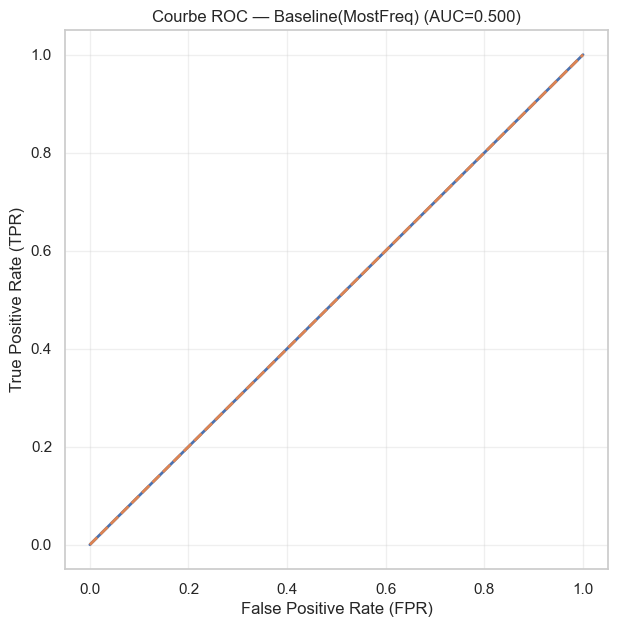

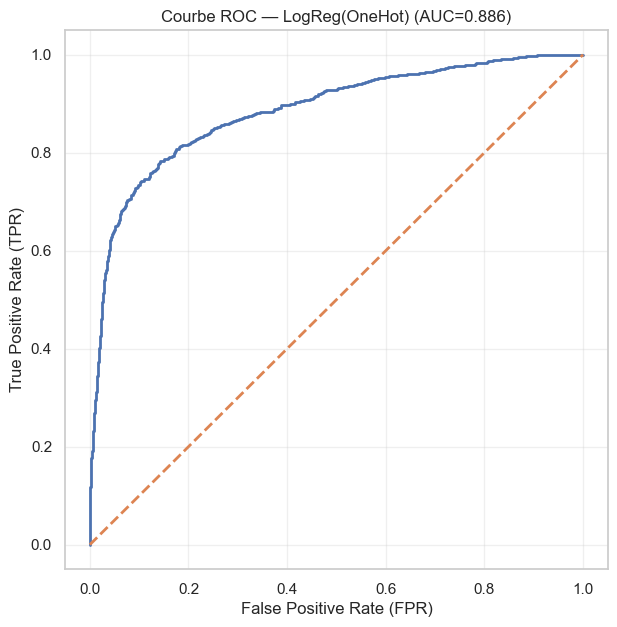

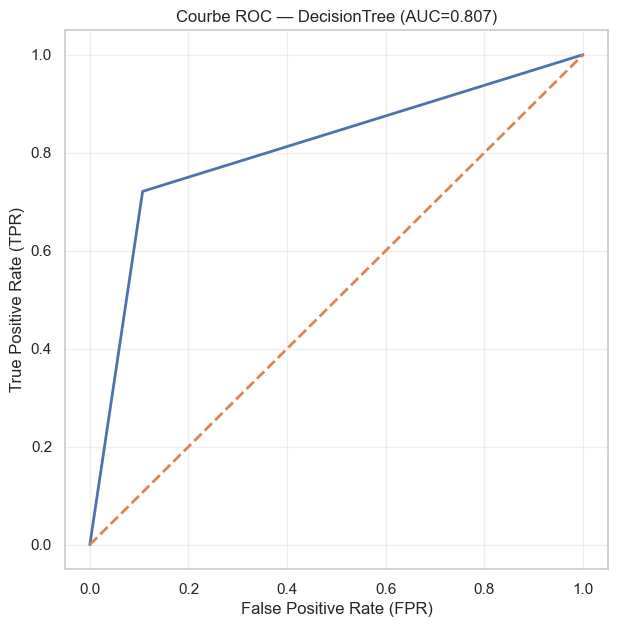

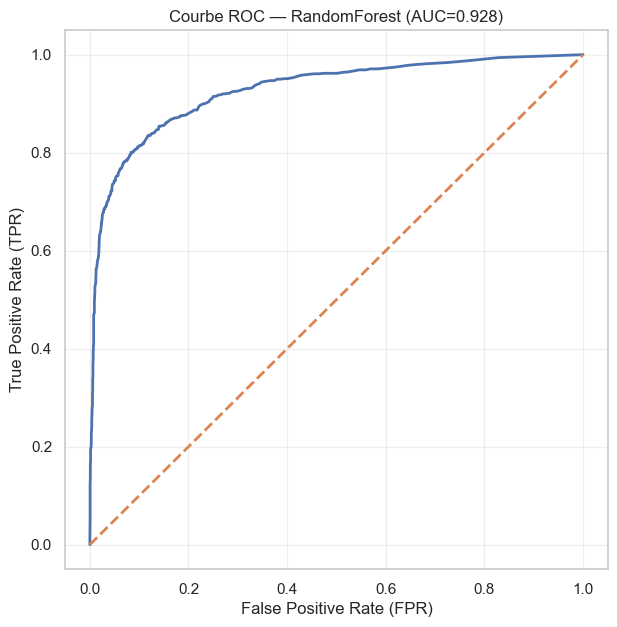

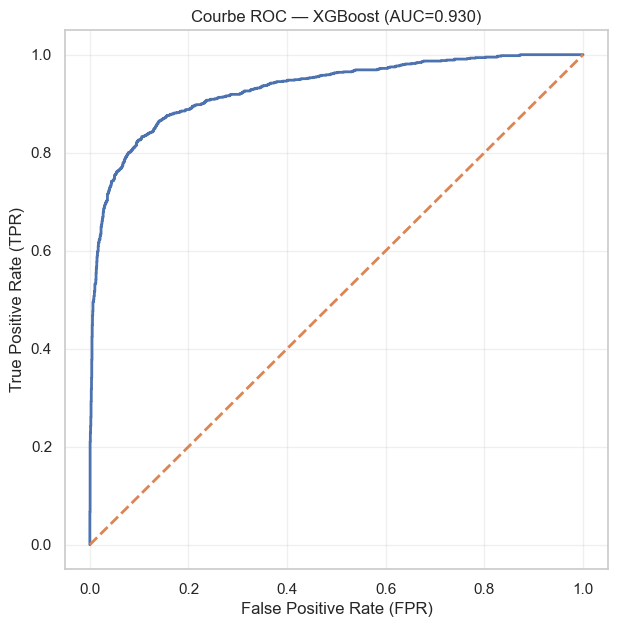

In [22]:
# Cellule 16 — ROC "une figure par modèle" 

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

if len(np.unique(y_test)) < 2:
    print("ROC impossible: y_test ne contient qu'une seule classe.")
else:
    for name, model in models_uni.items():
        # Fit sur train uniquement
        model.fit(X_train, y_train)

        # Score pour ROC
        y_score = None
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)[:, 1]
        elif hasattr(model, "decision_function"):
            y_score = model.decision_function(X_test)
        else:
            print(f"[WARN] {name} : ni predict_proba ni decision_function -> ROC non tracée.")
            continue

        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(7, 7))
        plt.plot(fpr, tpr, lw=2)
        plt.plot([0, 1], [0, 1], lw=2, linestyle="--")
        plt.xlabel("False Positive Rate (FPR)")
        plt.ylabel("True Positive Rate (TPR)")
        plt.title(f"Courbe ROC — {name} (AUC={roc_auc:.3f})")
        plt.grid(True, alpha=0.3)
        plt.show()


## Courbe ROC — **XGBoost** *(AUC = 0.930)*

- **Ce que dit l’AUC (0.930)** : le modèle **classe très bien** les arbres “défaut” vs “non défaut”.
  Concrètement, si on prend au hasard un arbre avec défaut et un sans défaut, XGBoost met le bon plus haut dans ~**93%** des cas.
- la montée est très rapide au début → on obtient un **TPR élevé avec un FPR faible**.
  C’est intéressant en pratique : on peut détecter beaucoup de défauts tout en générant relativement peu de fausses alertes.
-  XGBoost capte des **relations non-linéaires** et des **interactions** entre variables, ce qui est souvent le cas en diagnostic.

## Courbe ROC — **Random Forest** *(AUC = 0.928)*

- Random Forest est presque au même niveau que le XGBoost (0.928 vs 0.930).
  Sur ce problème, les deux modèles offrent une **capacité de classement excellente**.
- très bonne “pente” au départ → le modèle récupère une grande partie des vrais défauts
  pour une petite augmentation des faux positifs (zone FPR faible).
- Random Forest est souvent **stable** et moins sensible à certains choix d’hyperparamètres,
  ce qui en fait un très bon candidat “production” quand on veut un modèle fiable.

## Courbe ROC — **Régression Logistique (One-Hot)** *(AUC = 0.886)*

- **AUC=0.886** : le modèle est **bon**, mais en dessous des ensembles.
  Il capte une partie importante du signal, mais manque certaines subtilités.
- une logistique (même avec one-hot) approxime une séparation plutôt linéaire.

## Courbe ROC — **Arbre de décision** *(AUC = 0.807)*

- **AUC=0.807** : l’arbre fait mieux que le hasard, mais reste **nettement derrière** les autres modèles.
- **Courbe “en segments”** : on voit peu de “paliers” → cela arrive quand le modèle produitpeu de scores de probabilité distincts (prédictions plus “brutales”).
  Résultat : moins de flexibilité pour ajuster le seuil finement.
- **Interprétabilité vs performance** : l’arbre est très utile pour expliquer des règles,
  mais il généralise souvent moins bien qu’un ensemble.

In [19]:
# Validation croisée 

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

scoring = {
    "acc": "accuracy",
    "bal_acc": "balanced_accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc",
    "ap": "average_precision"
}

cv_rows = []
for name, model in models_uni.items():
    out = cross_validate(model, X_raw, y_defaut, cv=cv, scoring=scoring, n_jobs=-1)
    row = {"model": name}
    for k in scoring:
        row[k] = float(np.mean(out["test_" + k]))
    cv_rows.append(row)

cv_uni = pd.DataFrame(cv_rows).sort_values("bal_acc", ascending=False)
display(cv_uni)

,model,acc,bal_acc,precision,recall,f1,roc_auc,ap
4,XGBoost,0.873041,0.857660,0.799621,0.813641,0.806456,0.928123,0.887966
3,RandomForest,0.877463,0.847939,0.844903,0.763452,0.801975,0.925733,0.880804
1,LogReg(OneHot),0.835642,0.814875,0.743457,0.755448,0.749340,0.886966,0.821088
2,DecisionTree,0.837008,0.812315,0.753457,0.741653,0.747429,0.812315,0.642844
0,Baseline(MostFreq),0.674732,0.500000,0.000000,0.000000,0.000000,0.500000,0.325268


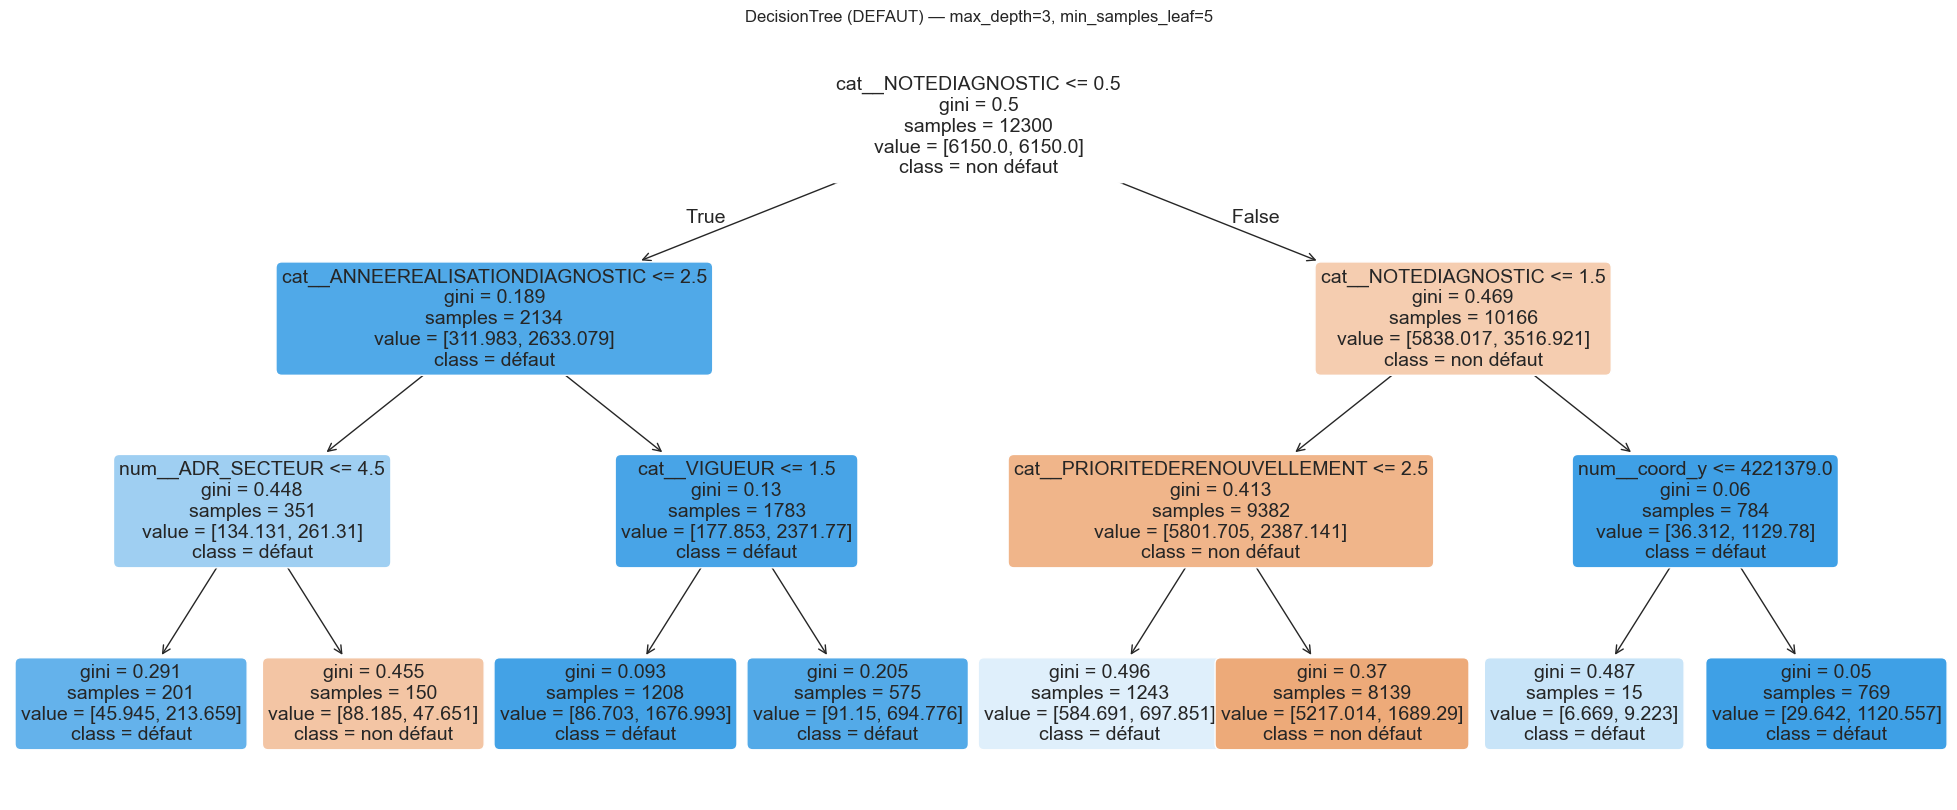

In [ ]:
# Arbre de décision  

from sklearn.base import clone
from sklearn.tree import DecisionTreeClassifier, plot_tree
import numpy as np
import matplotlib.pyplot as plt

# 1) Prétraitement : fit sur train uniquement
prep = clone(preprocess_ordinal)
X_train_tr = prep.fit_transform(X_train)
X_test_tr  = prep.transform(X_test)

# Si jamais c'est sparse, on convertit pour plot_tree
try:
    import scipy.sparse as sp
    if sp.issparse(X_train_tr):
        X_train_tr = X_train_tr.toarray()
except Exception:
    pass

# 2) Récupérer les noms de features après ColumnTransformer
try:
    feature_names = prep.get_feature_names_out()
except Exception:
    # Fallback (sklearn ancien) : au moins des noms lisibles
    feature_names = np.array([*num_cols, *cat_cols], dtype=object)

# 3) Arbre court et lisible 
tree = DecisionTreeClassifier(
    criterion="gini",
    random_state=100,
    max_depth=3,
    min_samples_leaf=5,
    class_weight="balanced"
)
tree.fit(X_train_tr, y_train)

# 4) Class names (ordre = tree.classes_ généralement [0,1])
name_map = {0: "non défaut", 1: "défaut"}
class_names = [name_map.get(int(c), str(c)) for c in tree.classes_]

plt.figure(figsize=(25, 10))
a = plot_tree(
    tree,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    rounded=True,
    fontsize=14
)
plt.title("DecisionTree (DEFAUT) — max_depth=3, min_samples_leaf=5")
plt.show()


## Arbre de décision (DEFAUT) — *max_depth=3, min_samples_leaf=5*

Cet arbre a été volontairement limité en profondeur pour rester **lisible**. Il ne cherche donc pas la meilleure performance,
mais plutôt à donner une idée **des règles principales** qui influencent la prédiction.

### 1) Variable la plus importante : **NOTE DIAGNOSTIC**
La première séparation (tout en haut) se fait sur `NOTEDIAGNOSTIC`.  
C’est un signal fort : **la note issue du diagnostic** résume déjà une grande partie de l’information sur l’état de l’arbre.
- Quand `NOTEDIAGNOSTIC` indique un état plutôt correct, l’arbre va plus souvent vers **“non défaut”**.
- Quand la note est moins bonne, l’arbre explore d’autres facteurs pour décider si on bascule vers **“défaut”**.

### 2) Pour confirmer un défaut, l’arbre regarde ensuite des critères “terrain”
Quand on est dans une zone où le défaut devient plausible, l’arbre utilise notamment :
- `ANNEEREALISATIONDIAGNOSTIC` : l’idée est que la date du diagnostic change le contexte (diagnostic récent vs ancien).
- `VIGUEUR` : une vigueur faible est logiquement associée à une probabilité plus élevée de défaut.
- `PRIORITEDERENOUVELLEMENT` : si un renouvellement est jugé prioritaire, cela va souvent dans le sens d’un état dégradé.
- `ADR_SECTEUR` : le secteur peut jouer (différences de conditions locales, environnement, pratiques d’entretien, etc.).
- `coord_y` : la position géographique intervient parfois comme proxy d’un environnement particulier.

### 3) Résumé
- L’arbre confirme une intuition simple : les variables de diagnostic (note, vigueur, priorité de renouvellement) structurent fortement la décision.
- Les variables de localisation (`secteur`, `coord_y`) semblent jouer un rôle secondaire : elles affinent la décision dans certains cas.

### 4) Limites (Ce qui est normal pour un arbre limité en profondeur)
- Les seuils exacts (ex. `<= 0.5`, `<= 1.5`) viennent de l’encodage ordinaldes catégories : ils ne sont pas directement “métier”,
  mais indiquent simplement des groupes de modalités.
- Un arbre de profondeur 3 ne capture pas toutes les interactions. C’est donc une **explication simplifiée**,
  à mettre en regard des modèles plus performants (Random Forest / XGBoost).

# DÉFI 1 — Tâche 2 : MULTI-LABEL (Collet/Houppier/Racine/Tronc)

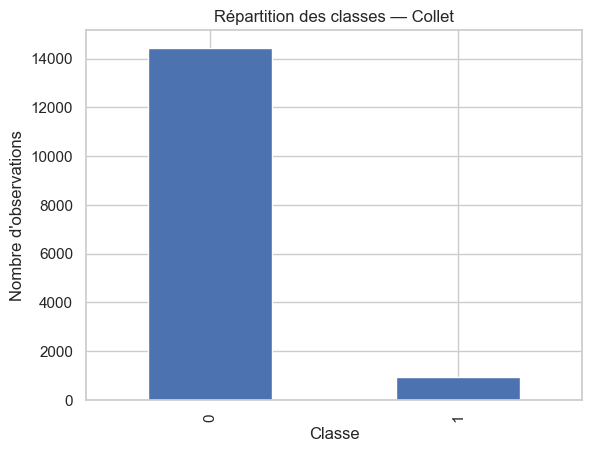

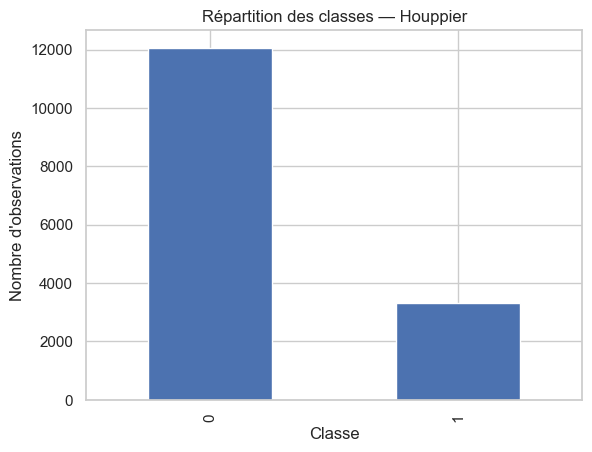

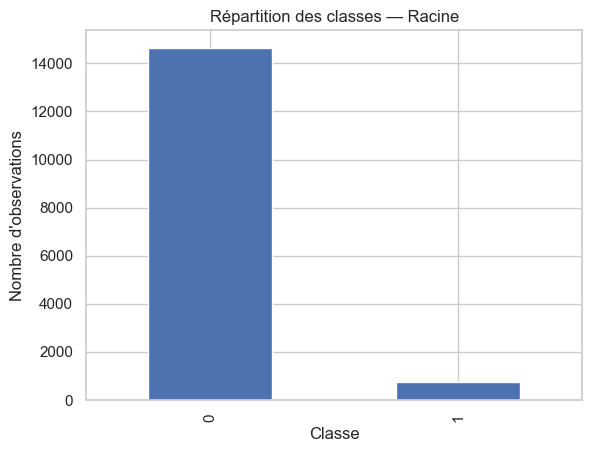

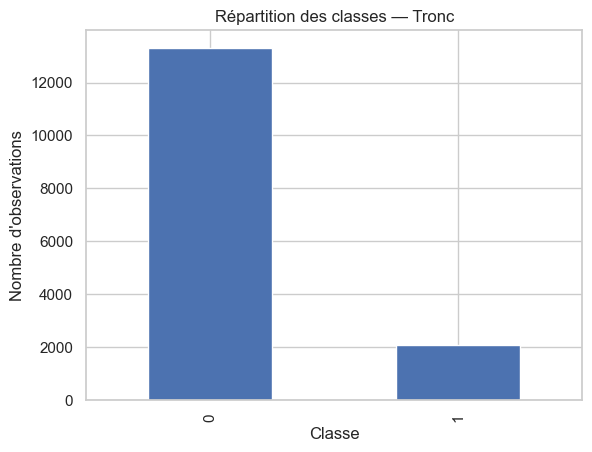

In [23]:
# Y multi-label + distributions 

label_cols = [c for c in ['Collet', 'Houppier', 'Racine', 'Tronc'] if c in data_new.columns]
assert len(label_cols) == 4, f"Labels attendus manquants. Présents: {label_cols}"

Y_multi = data_new[label_cols].astype(int)

for c in label_cols:
    data_new[c].value_counts().plot(kind="bar")
    plt.title(f"Répartition des classes — {c}")
    plt.xlabel("Classe")
    plt.ylabel("Nombre d'observations")
    plt.show()

In [24]:
# Split multi-label 

strat = Y_multi.sum(axis=1)

X_train_m, X_test_m, Y_train_m, Y_test_m = train_test_split(
    X_raw, Y_multi, test_size=0.2, random_state=RANDOM_STATE, stratify=strat
)

print("Train:", X_train_m.shape, "Test:", X_test_m.shape)
print("Distrib nb labels (train):\n", Y_train_m.sum(axis=1).value_counts().sort_index())
print("Distrib nb labels (test):\n", Y_test_m.sum(axis=1).value_counts().sort_index())


Train: (12300, 18) Test: (3075, 18)
Distrib nb labels (train):
 0    8299
1    2800
2     838
3     307
4      56
Name: count, dtype: int64
Distrib nb labels (test):
 0    2075
1     700
2     209
3      77
4      14
Name: count, dtype: int64


In [25]:
# Fonction d'undersampling 

rus = RandomUnderSampler(random_state=RANDOM_STATE)

def undersample_on_train(Xtr, ytr):
    Xr, yr = rus.fit_resample(Xtr, ytr)
    return Xr, yr

In [ ]:
# Modèles 

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

def build_models_bin():
    return {
        "Régression Logistique": Pipeline([
            ("prep", preprocess_onehot),
            ("clf", LogisticRegression(
                random_state=RANDOM_STATE,
                max_iter=5000,
                n_jobs=-1,
                class_weight="balanced",
                solver="saga"
            ))
        ]),
        "Random Forest": Pipeline([
            ("prep", preprocess_ordinal),
            ("clf", RandomForestClassifier(
                n_estimators=400,
                random_state=RANDOM_STATE,
                n_jobs=-1,
                class_weight="balanced_subsample"
            ))
        ]),
        "XGBoost": Pipeline([
            ("prep", preprocess_ordinal),
            ("clf", xgb.XGBClassifier(
                n_estimators=600,
                learning_rate=0.05,
                max_depth=6,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_lambda=1.0,
                objective="binary:logistic",
                eval_metric="logloss",
                n_jobs=-1,
                random_state=RANDOM_STATE,
                # on undersample => données ~ équilibrées => spw ~ 1
                scale_pos_weight=1.0
            ))
        ]),
        "Arbre de décision": Pipeline([
            ("prep", preprocess_ordinal),
            ("clf", DecisionTreeClassifier(
                random_state=RANDOM_STATE,
                class_weight="balanced",
                max_depth=6
            ))
        ]),
    }

In [28]:
# Micro: 1 tableau par label (Accuracy/Précision/Rappel/AUC + CrossVal K=10)
# + stockage des probas pour tracer ROC ensuite

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def eval_label_once(model, Xtr, ytr, Xte, yte):
    model.fit(Xtr, ytr)
    pred = model.predict(Xte)
    proba = model.predict_proba(Xte)[:, 1] if hasattr(model, "predict_proba") else None

    out = {
        "Accuracy": accuracy_score(yte, pred),
        "Précision": precision_score(yte, pred, zero_division=0),
        "Rappel": recall_score(yte, pred, zero_division=0),
        "F1": f1_score(yte, pred, zero_division=0),
    }
    if proba is not None and len(np.unique(yte)) > 1:
        out["AUC"] = roc_auc_score(yte, proba)
    else:
        out["AUC"] = np.nan

    return out, pred, proba

cv10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
scoring_cv = {"acc": "accuracy", "auc": "roc_auc"}

micro_tables = {}      # label -> DataFrame résultats
proba_store = {}       # (label, modelname) -> proba sur test

for lab in label_cols:
    print(f"\n==================== {lab} ====================")

    ytr = Y_train_m[lab].astype(int)
    yte = Y_test_m[lab].astype(int)

    # undersampling sur TRAIN uniquement 
    Xr, yr = undersample_on_train(X_train_m, ytr)

    print("Avant undersampling:", ytr.value_counts().to_dict())
    print("Après  undersampling:", pd.Series(yr).value_counts().to_dict())

    rows = []
    models_bin = build_models_bin()

    for mname, model in models_bin.items():
        # Cross-val K=10 sur le TRAIN rééquilibré 
        cv_out = cross_validate(model, Xr, yr, cv=cv10, scoring=scoring_cv, n_jobs=-1)
        cv_acc = float(np.mean(cv_out["test_acc"]))
        cv_auc = float(np.mean(cv_out["test_auc"]))

        # Éval test
        metrics, pred, proba = eval_label_once(model, Xr, yr, X_test_m, yte)

        rows.append({
            "Modèle": mname,
            "Accuracy": metrics["Accuracy"],
            "Précision": metrics["Précision"],
            "Rappel": metrics["Rappel"],
            "Score AUC": metrics["AUC"],
            "Cross Val Acc (K=10)": cv_acc,
            "Cross Val AUC (K=10)": cv_auc
        })

        if proba is not None:
            proba_store[(lab, mname)] = proba

    df_lab = pd.DataFrame(rows)

    pct_cols = ["Accuracy", "Précision", "Rappel", "Score AUC", "Cross Val Acc (K=10)", "Cross Val AUC (K=10)"]
    for c in pct_cols:
        df_lab[c] = (df_lab[c] * 100).round(2)

    micro_tables[lab] = df_lab
    display(df_lab)


==================== Collet ====================
Avant undersampling: {0: 11552, 1: 748}
Après  undersampling: {0: 748, 1: 748}


,Modèle,Accuracy,Précision,Rappel,Score AUC,Cross Val Acc (K=10),Cross Val AUC (K=10)
0,Régression Logistique,76.94,17.00,75.14,83.83,77.20,84.79
1,Random Forest,79.19,19.44,80.66,87.43,79.54,87.39
2,XGBoost,78.83,19.56,83.43,87.46,79.07,86.38
3,Arbre de décision,80.91,19.61,72.38,83.58,75.06,80.97



==================== Houppier ====================
Avant undersampling: {0: 9641, 1: 2659}
Après  undersampling: {0: 2659, 1: 2659}


,Modèle,Accuracy,Précision,Rappel,Score AUC,Cross Val Acc (K=10),Cross Val AUC (K=10)
0,Régression Logistique,83.84,58.45,83.84,90.09,82.57,89.01
1,Random Forest,84.88,60.21,85.82,92.88,84.02,91.48
2,XGBoost,85.59,61.66,85.82,93.27,84.26,91.96
3,Arbre de décision,83.19,57.89,77.74,87.86,80.63,86.01



==================== Racine ====================
Avant undersampling: {0: 11713, 1: 587}
Après  undersampling: {0: 587, 1: 587}


,Modèle,Accuracy,Précision,Rappel,Score AUC,Cross Val Acc (K=10),Cross Val AUC (K=10)
0,Régression Logistique,76.13,12.61,74.81,83.20,76.42,84.22
1,Random Forest,79.84,16.37,87.41,89.85,80.25,87.94
2,XGBoost,78.96,15.59,85.93,88.98,79.57,87.78
3,Arbre de décision,76.29,13.24,79.26,81.41,72.50,76.27



==================== Tronc ====================
Avant undersampling: {0: 10673, 1: 1627}
Après  undersampling: {0: 1627, 1: 1627}


,Modèle,Accuracy,Précision,Rappel,Score AUC,Cross Val Acc (K=10),Cross Val AUC (K=10)
0,Régression Logistique,80.91,39.84,69.75,82.07,77.75,84.37
1,Random Forest,78.57,37.39,77.37,85.54,80.27,86.94
2,XGBoost,79.87,39.36,79.45,85.83,79.16,86.69
3,Arbre de décision,83.45,44.24,67.44,81.92,78.18,83.06



==== Courbes ROC (2x2) — Collet ====


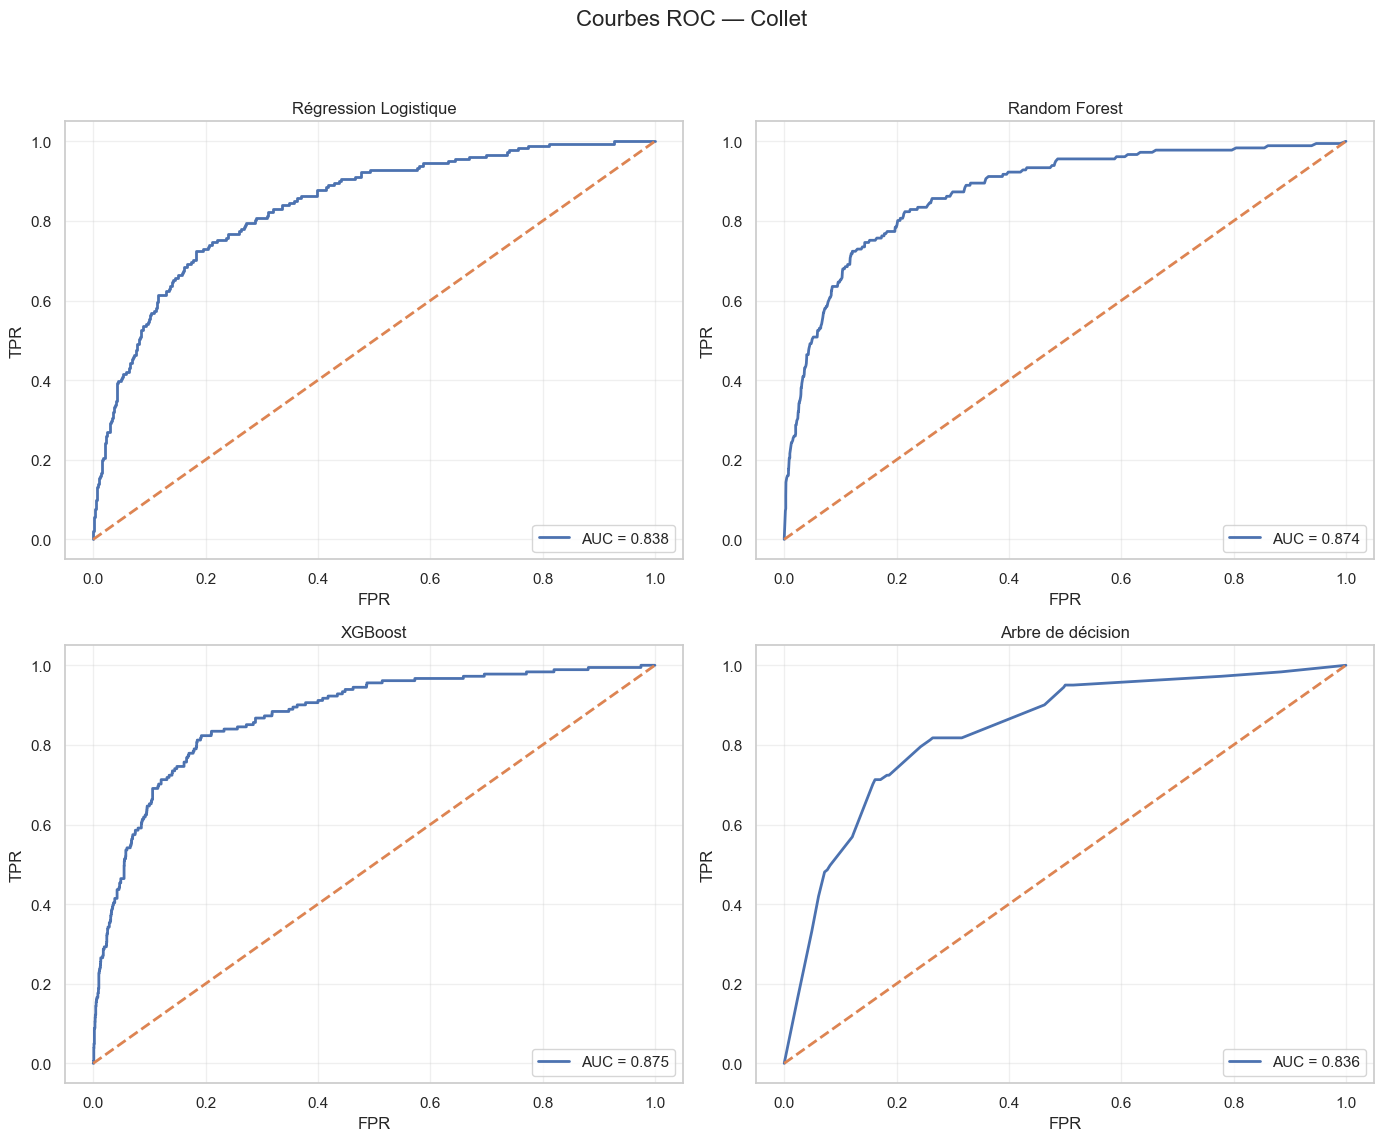


==== Courbes ROC (2x2) — Houppier ====


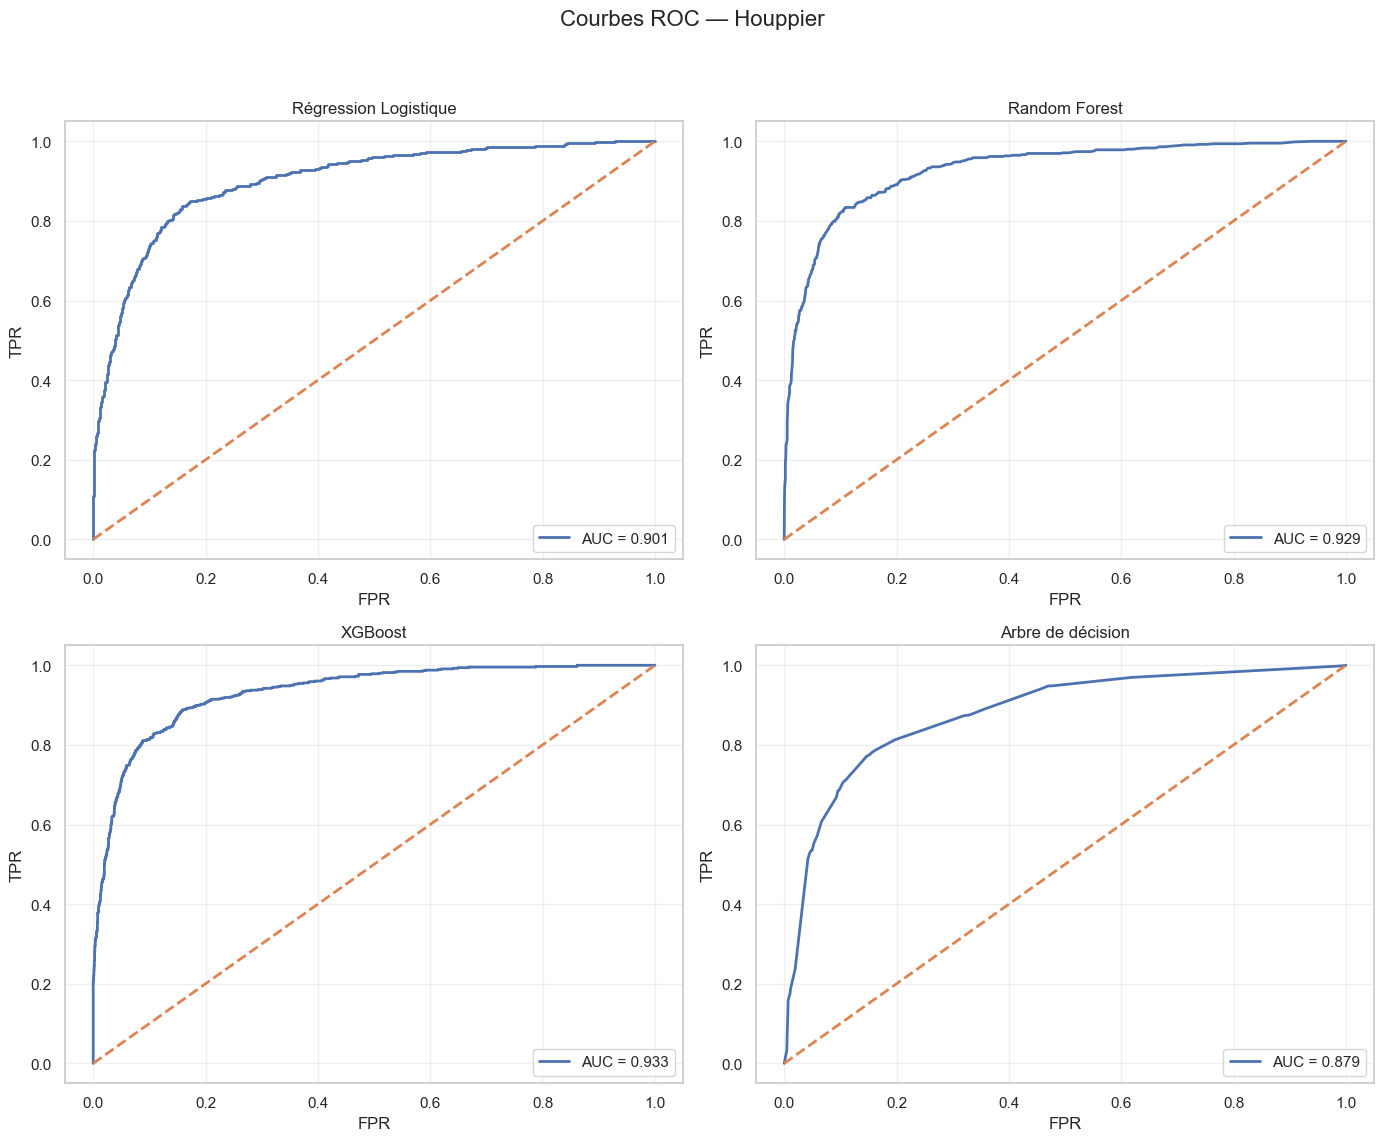


==== Courbes ROC (2x2) — Racine ====


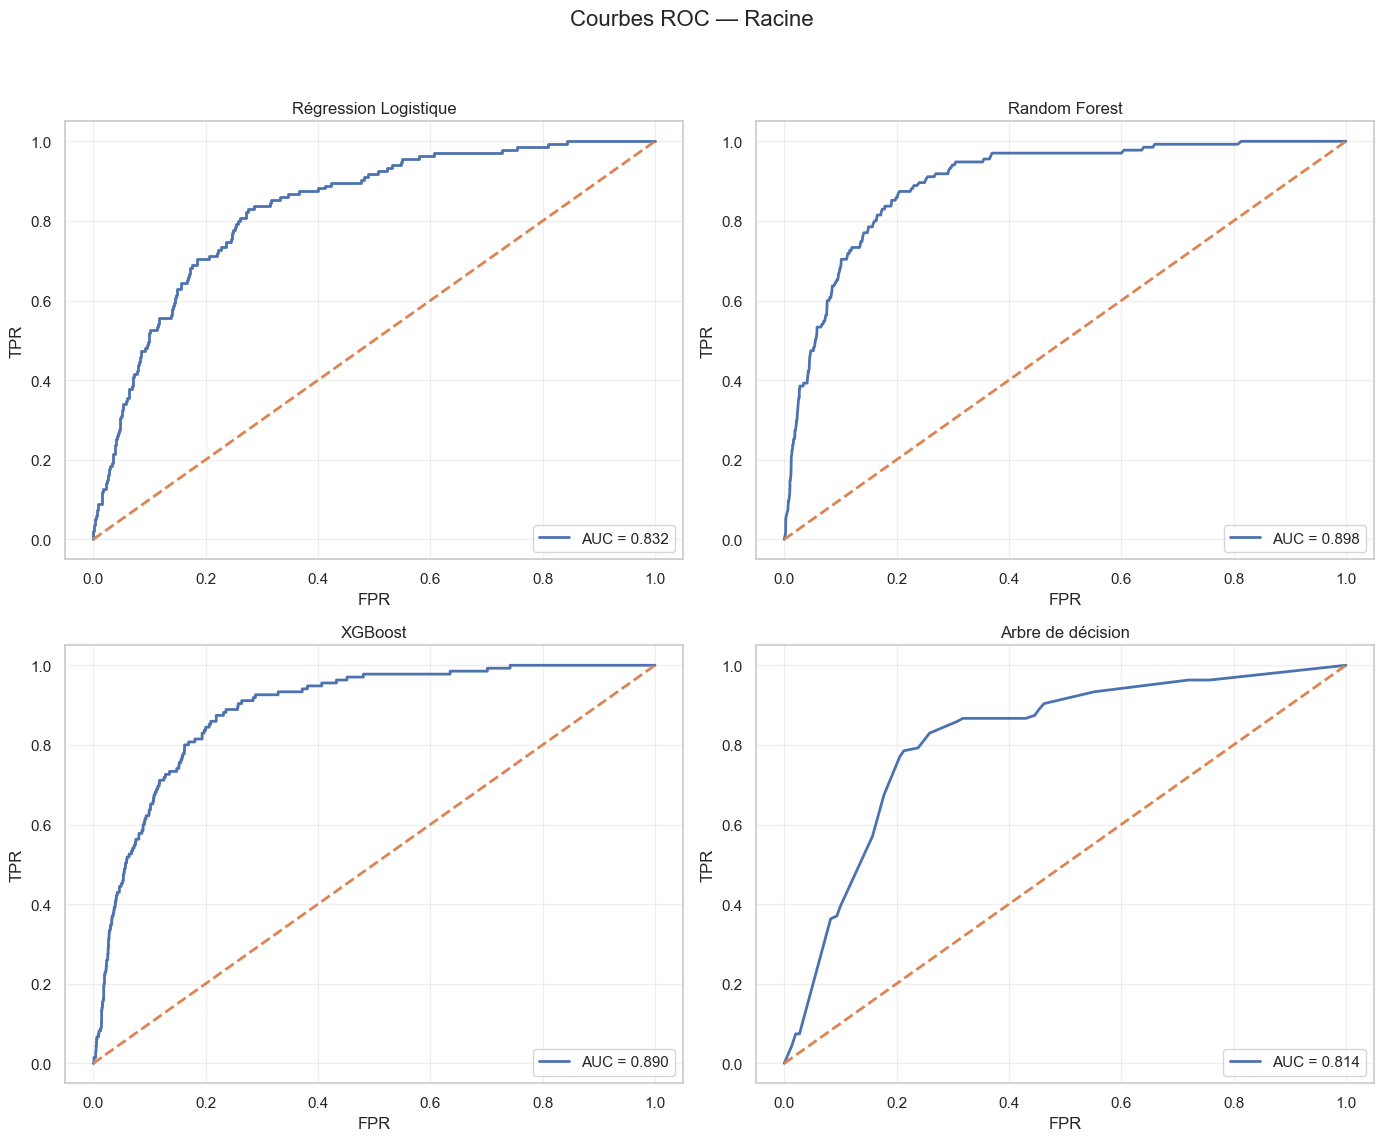


==== Courbes ROC (2x2) — Tronc ====


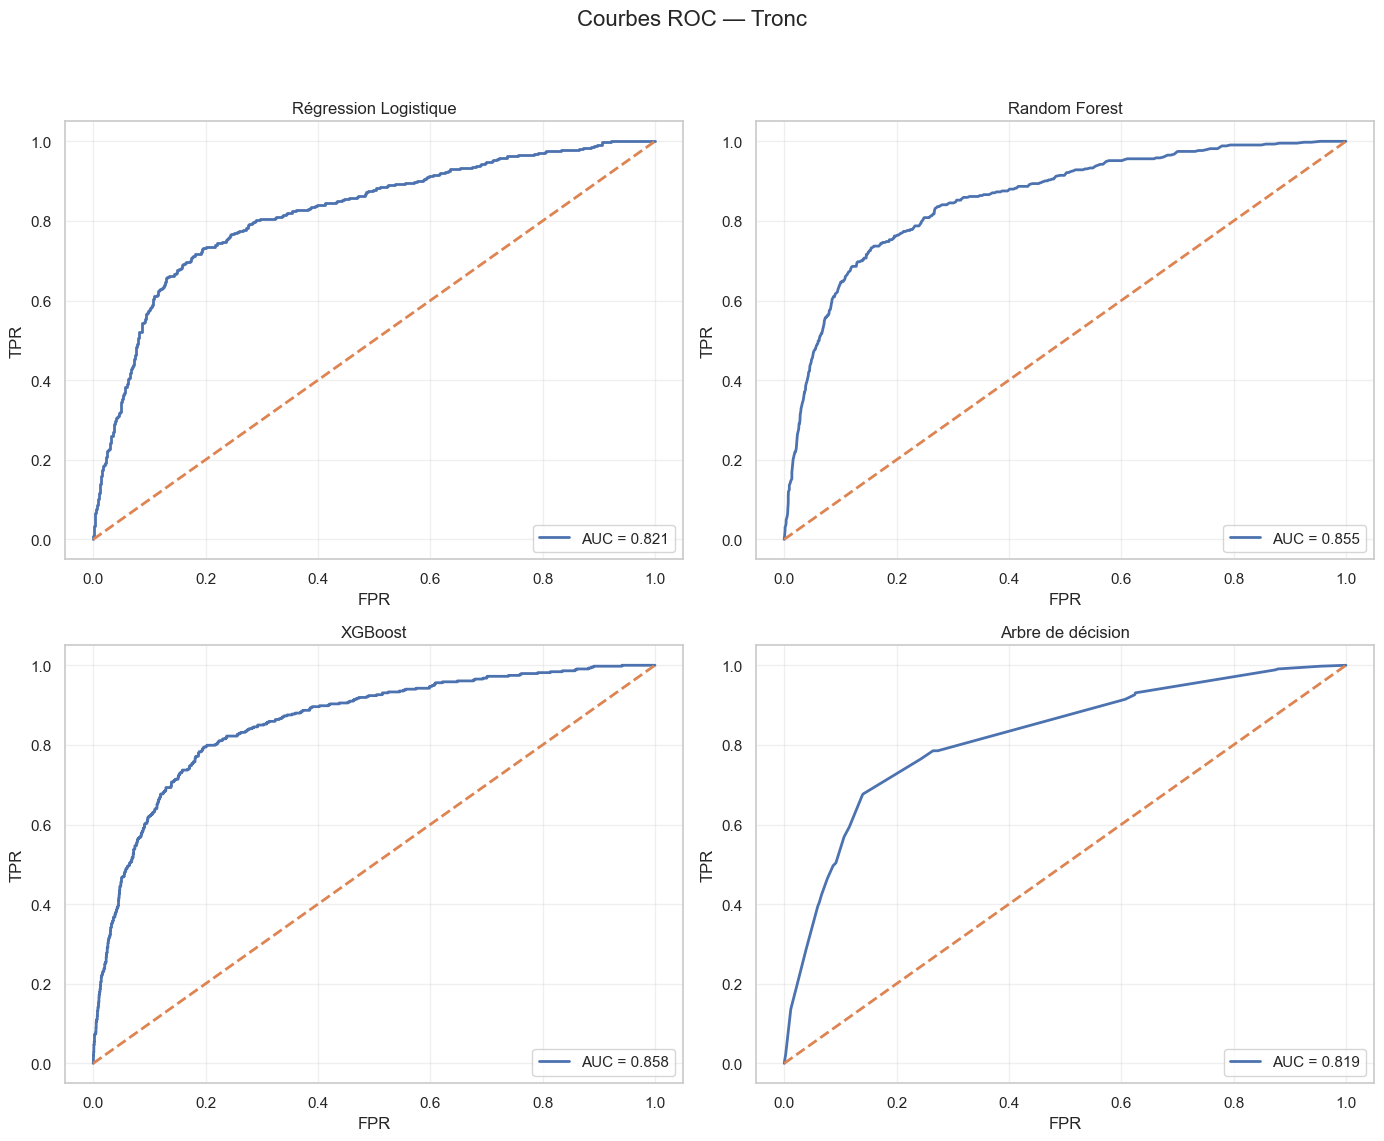

In [30]:
# Courbes ROC 
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

models_order = ["Régression Logistique", "Random Forest", "XGBoost", "Arbre de décision"]

for lab in label_cols:
    print(f"\n==== Courbes ROC (2x2) — {lab} ====")

    y_true = Y_test_m[lab].astype(int).values
    if len(np.unique(y_true)) < 2:
        print(f"ROC impossible pour {lab} : y_test ne contient qu'une seule classe.")
        continue

    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.ravel()

    for i, mname in enumerate(models_order):
        ax = axes[i]
        proba = proba_store.get((lab, mname), None)

        if proba is None:
            ax.set_title(f"{mname}\n[probas manquantes]")
            ax.axis("off")
            continue

        fpr, tpr, _ = roc_curve(y_true, proba)
        roc_auc = auc(fpr, tpr)

        ax.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
        ax.plot([0, 1], [0, 1], lw=2, linestyle="--")
        ax.set_xlabel("FPR")
        ax.set_ylabel("TPR")
        ax.set_title(f"{mname}")
        ax.grid(True, alpha=0.3)
        ax.legend(loc="lower right")

    fig.suptitle(f"Courbes ROC — {lab}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


## ROC 2×2 — **Tronc**
- Les meilleurs modèles sont **XGBoost (AUC≈0.858)** et **Random Forest (AUC≈0.855)**.
- **LogReg (0.821)** et **Arbre (0.819)** restent corrects mais moins bons.
- Ici, les modèles d’ensemble apportent un **petit gain régulier**.

## ROC 2×2 — **Racine**
- L’avantage des ensembles est clair : **Random Forest (AUC≈0.898)** et **XGBoost (AUC≈0.890)** dominent.
- **LogReg (0.832)** et surtout **Arbre (0.814)** sont en retrait.
- Cela suggère un problème plus **complexe / non-linéaire**, mieux capté par RF/XGB.

## ROC 2×2 — **Houppier**
- C’est le label le plus “facile” : toutes les courbes sont très au-dessus de la diagonale.
- **XGBoost (AUC≈0.933)** et **Random Forest (AUC≈0.929)** sont les meilleurs.
- **LogReg (0.901)** est très compétitive ; **Arbre (0.879)** est un peu derrière.

## ROC 2×2 — **Collet**
- Les ensembles restent devant : **XGBoost (AUC≈0.875)** et **Random Forest (AUC≈0.874)**.
- **LogReg (0.838)** et **Arbre (0.836)** sont proches mais légèrement inférieurs.
- Les écarts sont modestes, mais l’avantage des ensembles est constant.

In [31]:
# Macro : moyenne sur les 4 labels, par modèle
# (ici on moyenne Accuracy/Précision/Rappel/AUC sur Collet/Houppier/Racine/Tronc)

all_micro = pd.concat([micro_tables[lab].assign(Label=lab) for lab in label_cols], ignore_index=True)

macro = (all_micro
         .groupby("Modèle")[["Accuracy","Précision","Rappel","Score AUC"]]
         .mean()
         .round(2)
         .reset_index()
         .sort_values("Score AUC", ascending=False))

display(macro)

,Modèle,Accuracy,Précision,Rappel,Score AUC
1,Random Forest,80.62,33.35,82.82,88.92
3,XGBoost,80.81,34.04,83.66,88.88
2,Régression Logistique,79.46,31.98,75.89,84.80
0,Arbre de décision,80.96,33.75,74.20,83.69


In [32]:
# Métriques globales multi-label avec le "meilleur modèle" macro
# -> construit Y_hat complet (un classifieur par label) puis subset accuracy + hamming + micro/macro F1

from sklearn.metrics import accuracy_score, hamming_loss, precision_score, recall_score, f1_score

best_algo = macro.iloc[0]["Modèle"]
print("Meilleur modèle (macro):", best_algo)

Y_pred_hat = pd.DataFrame(index=Y_test_m.index)

for lab in label_cols:
    ytr = Y_train_m[lab].astype(int)
    Xr, yr = undersample_on_train(X_train_m, ytr)

    model = build_models_bin()[best_algo]
    model.fit(Xr, yr)
    Y_pred_hat[lab] = model.predict(X_test_m)

Y_true = Y_test_m.values
Y_hat = Y_pred_hat.values

print("Subset accuracy (exact match):", accuracy_score(Y_true, Y_hat))
print("Hamming loss:", hamming_loss(Y_true, Y_hat))
print("Micro F1:", f1_score(Y_true, Y_hat, average="micro", zero_division=0))
print("Macro F1:", f1_score(Y_true, Y_hat, average="macro", zero_division=0))


Meilleur modèle (macro): Random Forest
Subset accuracy (exact match): 0.527479674796748
Hamming loss: 0.1938211382113821
Micro F1: 0.49362786745964315
Macro F1: 0.4502187730931535


# Une autre méthode de classification Multi-Label

## MultiOutputClassifier

In [ ]:
# MultiOutputClassifier avec RandomForest

from sklearn.multioutput import MultiOutputClassifier

multi_rf = Pipeline([
    ("prep", preprocess_ordinal),
    ("clf", MultiOutputClassifier(
        RandomForestClassifier(
            n_estimators=400,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            class_weight="balanced_subsample"
        )
    ))
])

multi_rf.fit(X_train_m, Y_train_m)
Y_pred_multi = multi_rf.predict(X_test_m)

print("Subset accuracy (MultiOutput RF):", accuracy_score(Y_test_m.values, Y_pred_multi))
print("Hamming loss (MultiOutput RF):", hamming_loss(Y_test_m.values, Y_pred_multi))
print("\nRapport (MultiOutput RF):\n", classification_report(Y_test_m.values, Y_pred_multi, target_names=label_cols, digits=4))


Subset accuracy (MultiOutput RF): 0.7795121951219512
Hamming loss (MultiOutput RF): 0.07414634146341463

Rapport (MultiOutput RF):
               precision    recall  f1-score   support

      Collet     0.7073    0.3204    0.4411       181
    Houppier     0.8031    0.7088    0.7530       656
      Racine     0.5846    0.2815    0.3800       135
       Tronc     0.6764    0.4296    0.5254       433

   micro avg     0.7463    0.5317    0.6209      1405
   macro avg     0.6929    0.4351    0.5249      1405
weighted avg     0.7307    0.5317    0.6069      1405
 samples avg     0.1858    0.1743    0.1746      1405



In [36]:
# Récupérer les probabilités (MultiOutputClassifier) sous forme matrice (n_samples, 4)

import numpy as np

def multioutput_proba_matrix(multioutput_pipeline, X):
    """
    Retourne une matrice (n_samples, n_labels) de proba P(y=1) pour chaque label.
    Fonctionne avec Pipeline(prep + MultiOutputClassifier).
    """
    prob_list = multioutput_pipeline.predict_proba(X)  # liste de longueur n_labels
    cols = []
    for p in prob_list:
        p = np.asarray(p)
        if p.ndim == 1:
            cols.append(p)
        else:
            # si proba sur 2 classes => colonne 1
            if p.shape[1] >= 2:
                cols.append(p[:, 1])
            else:
                cols.append(p[:, 0])
    return np.vstack(cols).T

# Probas test MultiOutput
proba_multi_rf = multioutput_proba_matrix(multi_rf, X_test_m)  # (n_test, 4)
print("proba_multi_rf shape:", proba_multi_rf.shape)

proba_multi_rf shape: (3075, 4)


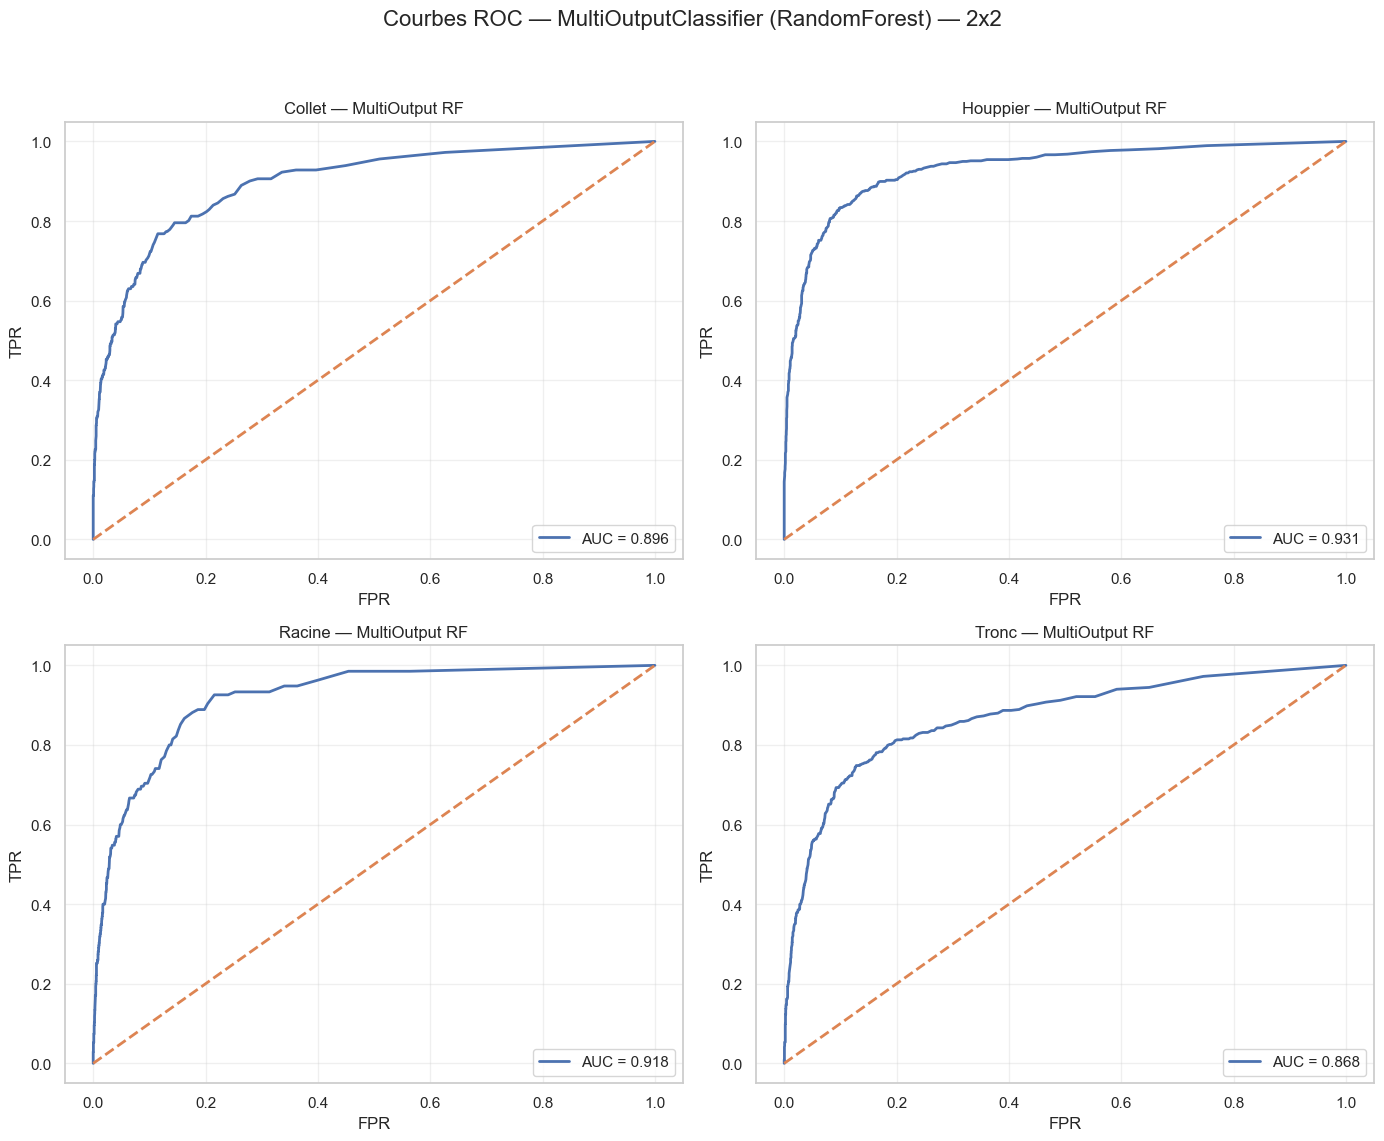

In [37]:
# ROC 2x2 (MultiOutput RF)

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for i, lab in enumerate(label_cols):
    ax = axes[i]
    y_true = Y_test_m[lab].astype(int).values
    y_score = proba_multi_rf[:, i]

    if len(np.unique(y_true)) < 2:
        ax.set_title(f"{lab}\nROC impossible (1 seule classe)")
        ax.axis("off")
        continue

    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
    ax.plot([0, 1], [0, 1], lw=2, linestyle="--")
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.set_title(f"{lab} — MultiOutput RF")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="lower right")

fig.suptitle("Courbes ROC — MultiOutputClassifier (RandomForest) — 2x2", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## ROC (2×2) — **MultiOutputClassifier (RandomForest)**

- Les courbes ROC sont très bonnes et **identiques** à Binary Relevance (mêmes AUC).
- **Houppier** est le plus facile (AUC ≈ 0.931), puis **Racine** (≈ 0.918), **Collet** (≈ 0.896) et **Tronc** (≈ 0.868).
- Cela confirme que le modèle sépare bien les classes, mais que le vrai défi (sur labels rares) se voit mieux sur Precision–Recall.

En bref : bonne capacité de classement, mais seuil/compromis précision–rappel à gérer sur les labels rares.

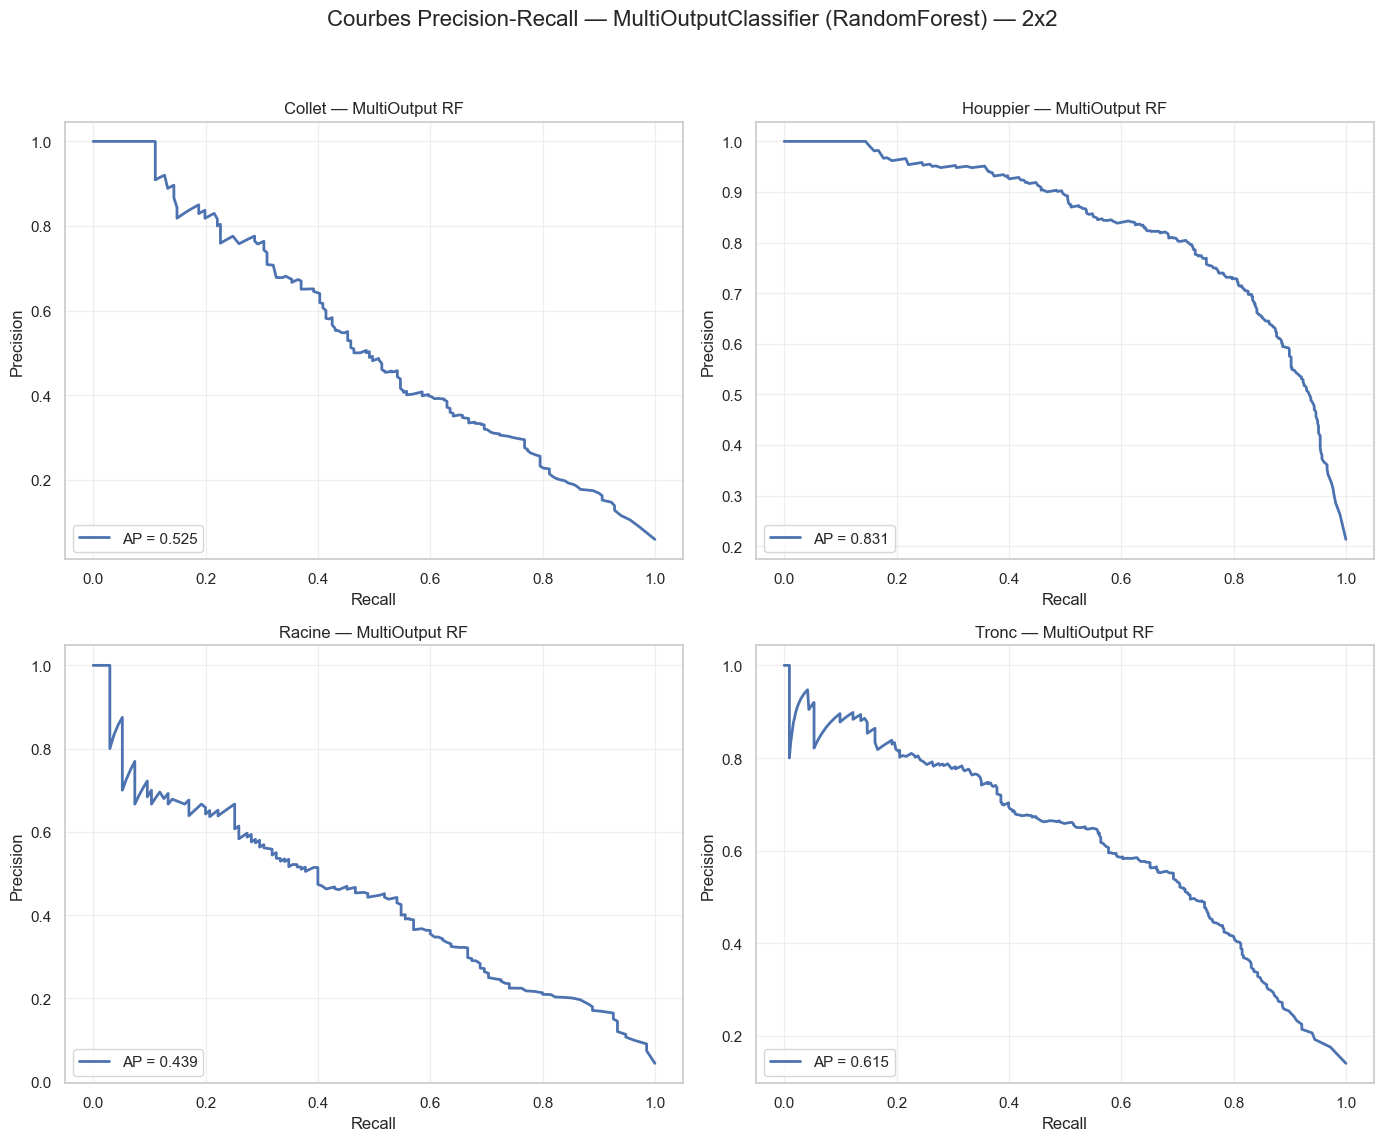

In [38]:
# Precision-Recall 2x2 (MultiOutput RF) + AP

from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for i, lab in enumerate(label_cols):
    ax = axes[i]
    y_true = Y_test_m[lab].astype(int).values
    y_score = proba_multi_rf[:, i]

    if len(np.unique(y_true)) < 2:
        ax.set_title(f"{lab}\nPR impossible (1 seule classe)")
        ax.axis("off")
        continue

    prec, rec, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)

    ax.plot(rec, prec, lw=2, label=f"AP = {ap:.3f}")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(f"{lab} — MultiOutput RF")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="lower left")

fig.suptitle("Courbes Precision-Recall — MultiOutputClassifier (RandomForest) — 2x2", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Precision–Recall (2×2) — **MultiOutputClassifier (RandomForest)**

- Les courbes sont **quasi identiques** à Binary Relevance, ce qui est cohérent :
  dans les deux cas, on entraîne essentiellement une forêt par label.
- Même lecture :
  - **Houppier** ressort comme le label le plus “facile” (AP ≈ 0.831).
  - **Racine** et **Collet** restent les plus délicats (AP plus bas).
  - **Tronc** est entre les deux.

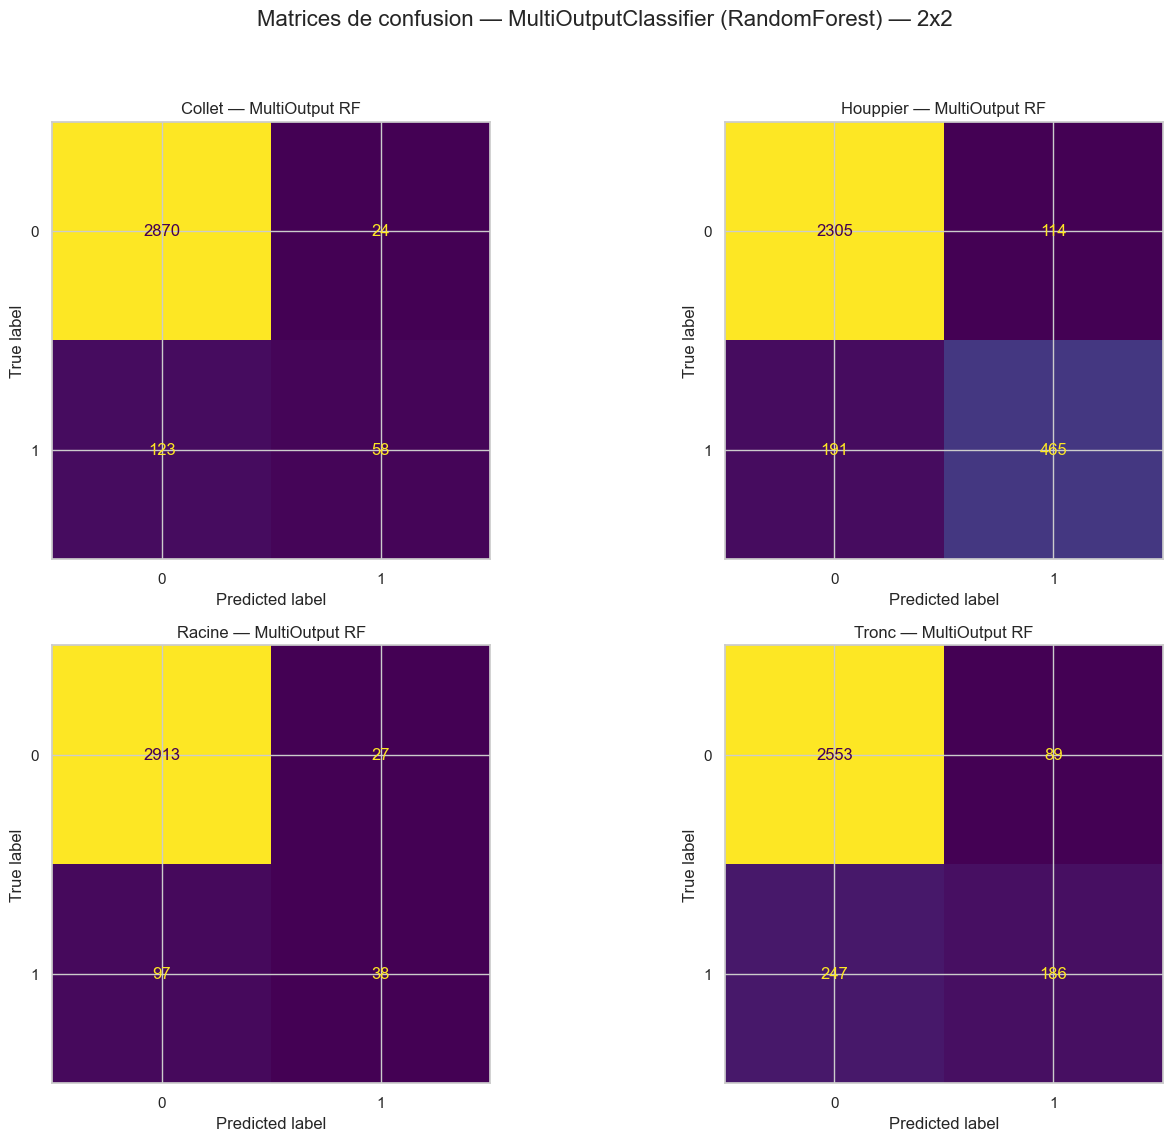

In [39]:
# Cellule 27.4 — Matrices de confusion 2x2 (MultiOutput RF)

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

Y_pred_multi = multi_rf.predict(X_test_m)  # (n_test, 4)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for i, lab in enumerate(label_cols):
    ax = axes[i]
    y_true = Y_test_m[lab].astype(int).values
    y_pred = Y_pred_multi[:, i].astype(int)

    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0","1"])
    disp.plot(ax=ax, values_format="d", colorbar=False)
    ax.set_title(f"{lab} — MultiOutput RF")

fig.suptitle("Matrices de confusion — MultiOutputClassifier (RandomForest) — 2x2", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Matrices de confusion (2×2) — **MultiOutputClassifier (RandomForest)**

- On retrouve les mêmes tendances que pour Binary Relevance :
  beaucoup de vrais négatifs (TN) et des erreurs plus visibles sur les labels rares.
- Sur **Houppier** et **Tronc**, les vrais positifs sont plus présents, donc les résultats sont plus réguliers.
- Sur **Collet** et **Racine**, le modèle hésite davantage → les faux positifs / faux négatifs pèsent plus lourd.

## Matrices de confusion (2×2) — **MultiOutputClassifier (RandomForest)**

- On retrouve les mêmes tendances que pour Binary Relevance :
  beaucoup de vrais négatifs (TN) et des erreurs plus visibles sur les labels rares.
- Sur **Houppier** et **Tronc**, les vrais positifs sont plus présents, donc les résultats sont plus réguliers.
- Sur **Collet** et **Racine**, le modèle hésite davantage → les faux positifs / faux négatifs pèsent plus lourd.

Conclusion : MultiOutput ne change pas vraiment la difficulté principale, qui reste la rareté des défauts sur certains attributs.

## BinaryRelevance

In [40]:
# BinaryRelevance 

from skmultilearn.problem_transform import BinaryRelevance

br = BinaryRelevance(
    classifier=RandomForestClassifier(
        n_estimators=400,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        class_weight="balanced_subsample"
    )
)

# IMPORTANT: BinaryRelevance veut du numpy / sparse, on preprocess d'abord
X_train_br = preprocess_ordinal.fit_transform(X_train_m)
X_test_br  = preprocess_ordinal.transform(X_test_m)

br.fit(X_train_br, Y_train_m.values)
Y_pred_br = br.predict(X_test_br)

# Y_pred_br est sparse -> convertir
Y_pred_br_dense = Y_pred_br.toarray()

print("Subset accuracy (BinaryRelevance RF):", accuracy_score(Y_test_m.values, Y_pred_br_dense))
print("Hamming loss (BinaryRelevance RF):", hamming_loss(Y_test_m.values, Y_pred_br_dense))
print("\nRapport (BinaryRelevance RF):\n", classification_report(Y_test_m.values, Y_pred_br_dense, target_names=label_cols, digits=4))


Subset accuracy (BinaryRelevance RF): 0.7795121951219512
Hamming loss (BinaryRelevance RF): 0.07414634146341463

Rapport (BinaryRelevance RF):
               precision    recall  f1-score   support

      Collet     0.7073    0.3204    0.4411       181
    Houppier     0.8031    0.7088    0.7530       656
      Racine     0.5846    0.2815    0.3800       135
       Tronc     0.6764    0.4296    0.5254       433

   micro avg     0.7463    0.5317    0.6209      1405
   macro avg     0.6929    0.4351    0.5249      1405
weighted avg     0.7307    0.5317    0.6069      1405
 samples avg     0.1858    0.1743    0.1746      1405



In [41]:
# Probas (BinaryRelevance RF) sous forme matrice (n_samples, 4)


proba_br = br.predict_proba(X_test_br)
try:
    proba_br = proba_br.toarray()
except Exception:
    proba_br = np.asarray(proba_br)

print("proba_br shape:", proba_br.shape)


proba_br shape: (3075, 4)


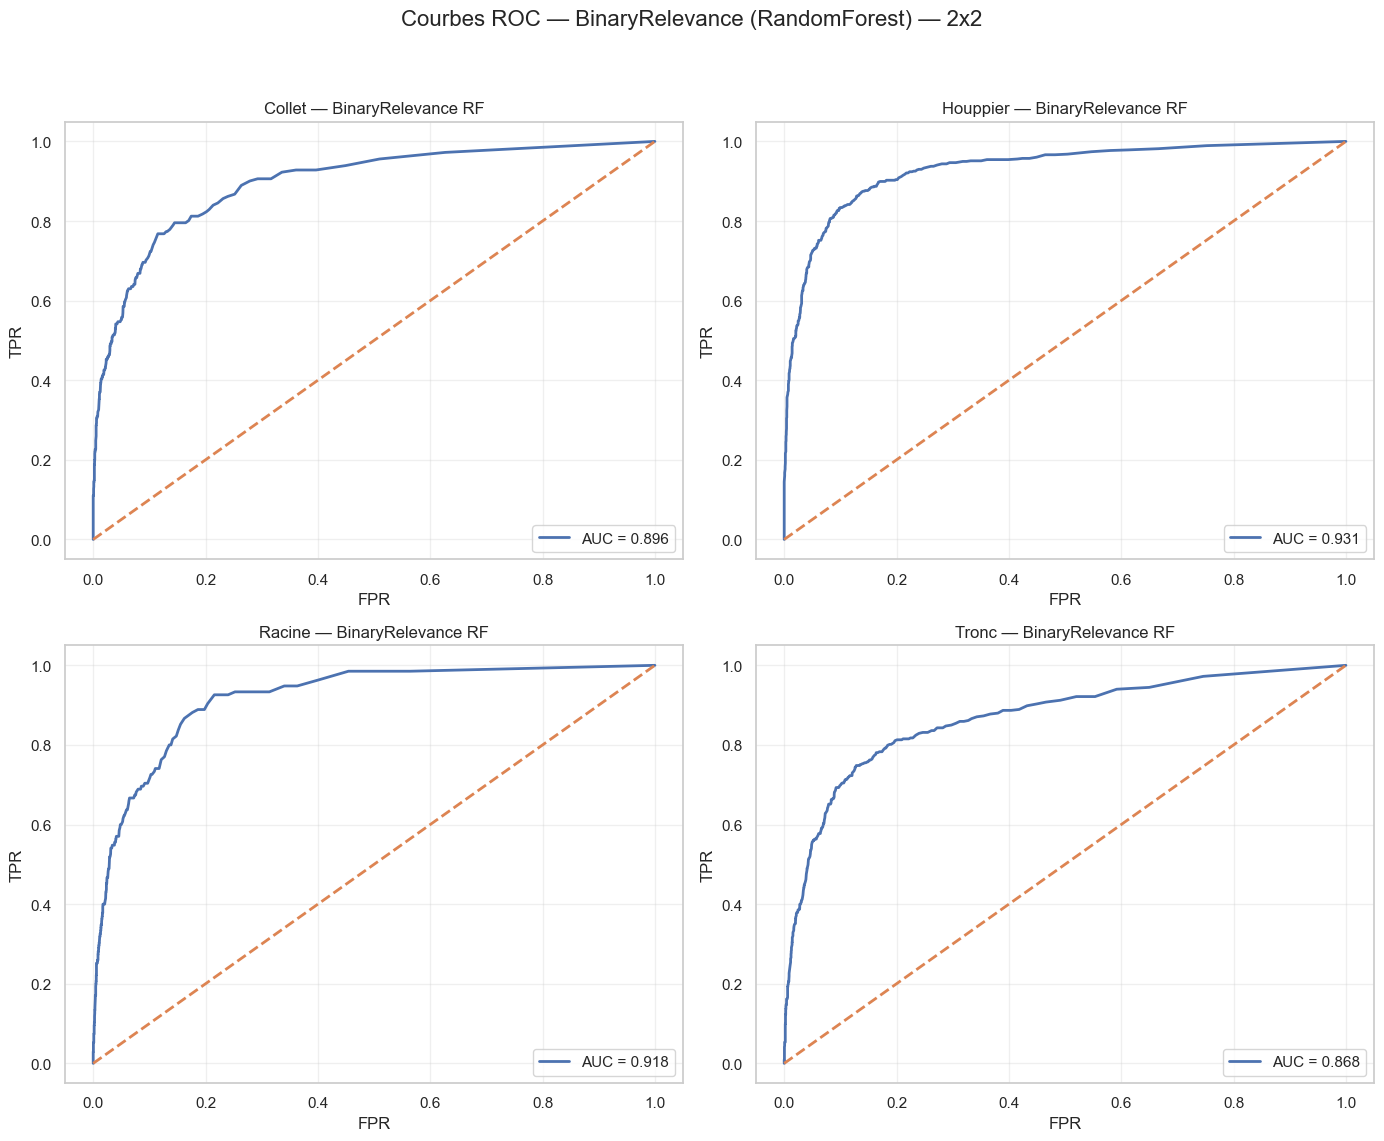

In [42]:
# ROC 2x2 (BinaryRelevance RF) + AUC

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for i, lab in enumerate(label_cols):
    ax = axes[i]
    y_true = Y_test_m[lab].astype(int).values
    y_score = proba_br[:, i]

    if len(np.unique(y_true)) < 2:
        ax.set_title(f"{lab}\nROC impossible (1 seule classe)")
        ax.axis("off")
        continue

    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
    ax.plot([0, 1], [0, 1], lw=2, linestyle="--")
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.set_title(f"{lab} — BinaryRelevance RF")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="lower right")

fig.suptitle("Courbes ROC — BinaryRelevance (RandomForest) — 2x2", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## ROC (2×2) — **Binary Relevance (RandomForest)**

- Les AUC sont élevées sur tous les labels → le modèle **classe bien** les exemples positifs vs négatifs.
- Meilleur comportement sur **Houppier** (AUC ≈ 0.931) et **Racine** (≈ 0.918).
- **Collet** (≈ 0.896) et **Tronc** (≈ 0.868) restent très corrects.

Point important : une bonne ROC ne garantit pas une précision élevée au seuil 0.5, surtout quand le label est rare.
C’est pour ça qu’on regarde aussi les courbes Precision–Recall.

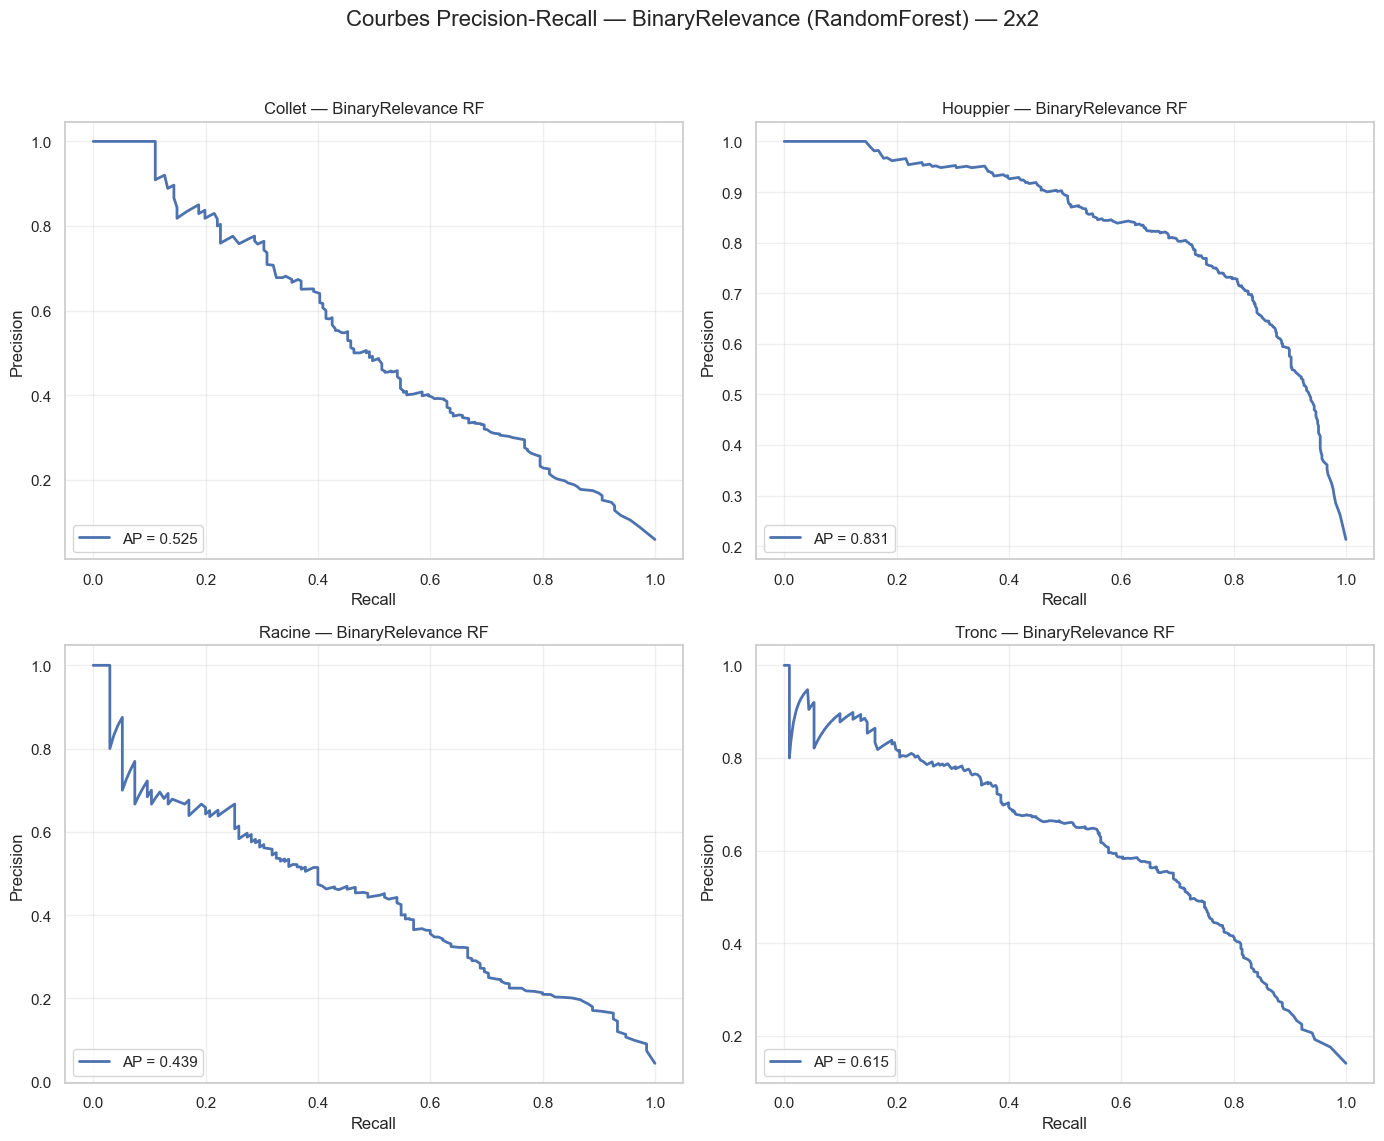

In [43]:
# Precision-Recall 2x2 (BinaryRelevance RF) + AP

from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for i, lab in enumerate(label_cols):
    ax = axes[i]
    y_true = Y_test_m[lab].astype(int).values
    y_score = proba_br[:, i]

    if len(np.unique(y_true)) < 2:
        ax.set_title(f"{lab}\nPR impossible (1 seule classe)")
        ax.axis("off")
        continue

    prec, rec, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)

    ax.plot(rec, prec, lw=2, label=f"AP = {ap:.3f}")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(f"{lab} — BinaryRelevance RF")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="lower left")

fig.suptitle("Courbes Precision-Recall — BinaryRelevance (RandomForest) — 2x2", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Precision–Recall (2×2) — **Binary Relevance (RandomForest)**

- Ces courbes sont très utiles ici car certains labels sont **rares** (ex. *Collet* et *Racine*).
- On voit un comportement logique :
  - **Houppier** a la meilleure courbe (AP élevé ≈ 0.831) → le modèle est souvent précis même quand on cherche beaucoup de rappel.
  - **Racine** et **Collet** sont plus difficiles (AP plus faible ≈ 0.439 et 0.525) → quand on pousse le rappel, la précision chute plus vite.
  - **Tronc** est intermédiaire (AP ≈ 0.615).

En clair : plus le label est rare, plus il est dur de garder une bonne précision à haut rappel. 

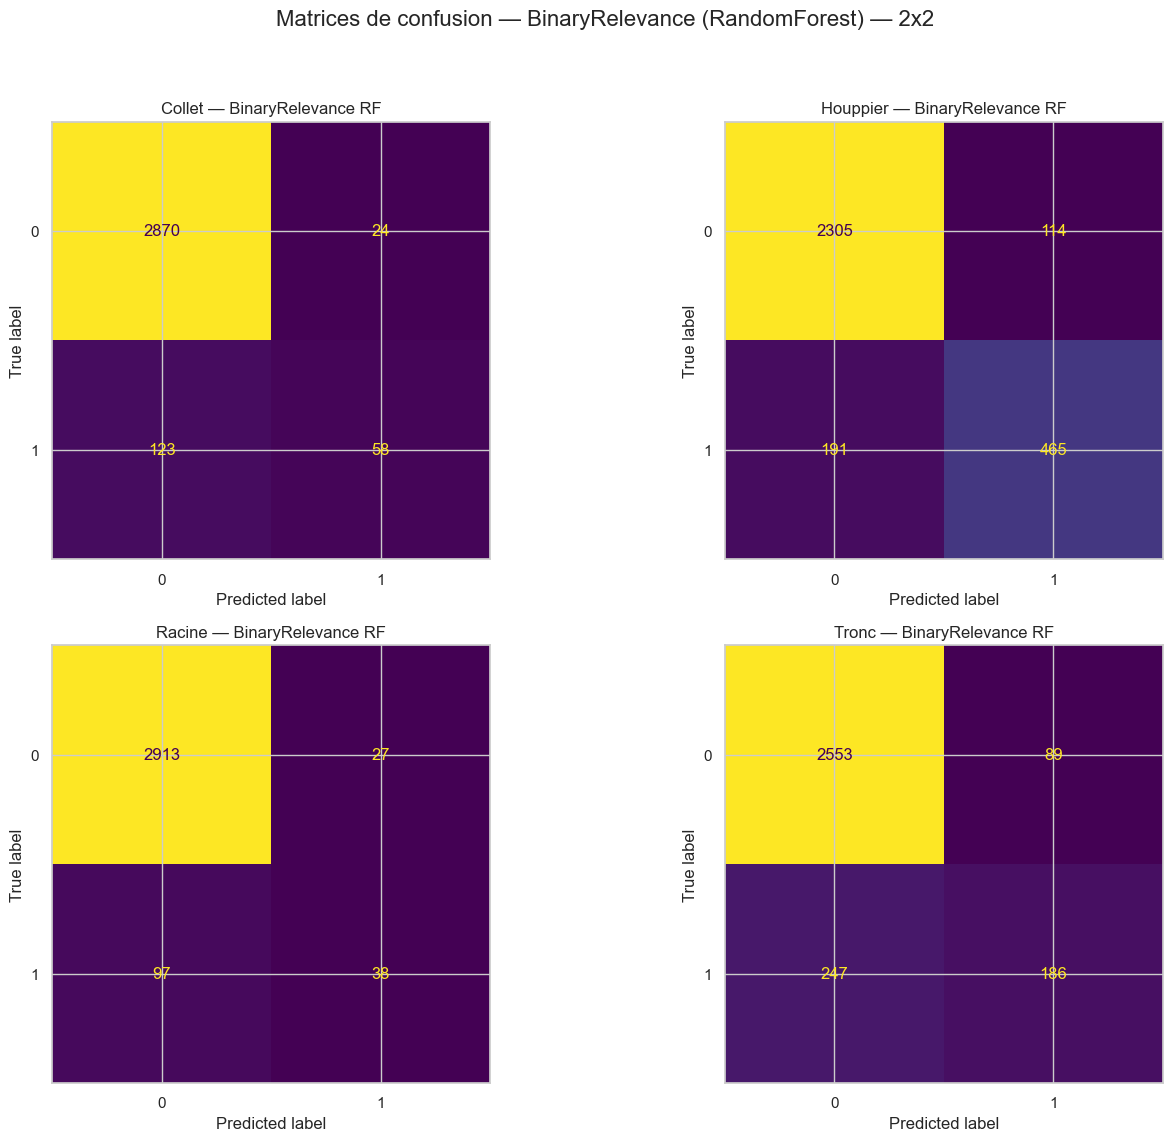

In [44]:
# Matrices de confusion 2x2 (BinaryRelevance RF)

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

Y_pred_br = br.predict(X_test_br)
try:
    Y_pred_br = Y_pred_br.toarray()
except Exception:
    Y_pred_br = np.asarray(Y_pred_br)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for i, lab in enumerate(label_cols):
    ax = axes[i]
    y_true = Y_test_m[lab].astype(int).values
    y_pred = Y_pred_br[:, i].astype(int)

    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0","1"])
    disp.plot(ax=ax, values_format="d", colorbar=False)
    ax.set_title(f"{lab} — BinaryRelevance RF")

fig.suptitle("Matrices de confusion — BinaryRelevance (RandomForest) — 2x2", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Matrices de confusion (2×2) — **Binary Relevance (RandomForest)**

- La majorité des exemples est en classe **0** (pas de défaut) → c’est normal d’avoir de gros nombres en haut à gauche (TN).
- Pour les labels rares (*Collet*, *Racine*), on observe souvent :
  - peu de vrais positifs (TP) car il y a peu de cas positifs au départ,
  - et quelques faux négatifs (FN) / faux positifs (FP) qui impactent beaucoup la précision/rappel.
- Pour *Houppier* et *Tronc*, les TP sont plus nombreux → les performances sont plus stables.

En bref : ces matrices confirment que la difficulté vient surtout des labels rares.

In [45]:
# Tableau comparatif AUC + AP par label (MultiOutput RF vs BinaryRelevance RF)

from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np
import pandas as pd

rows = []
for i, lab in enumerate(label_cols):
    y_true = Y_test_m[lab].astype(int).values

    if len(np.unique(y_true)) < 2:
        rows.append({"Label": lab, "AUC_Multi": np.nan, "AP_Multi": np.nan,
                     "AUC_BR": np.nan, "AP_BR": np.nan})
        continue

    rows.append({
        "Label": lab,
        "AUC_Multi": roc_auc_score(y_true, proba_multi_rf[:, i]),
        "AP_Multi": average_precision_score(y_true, proba_multi_rf[:, i]),
        "AUC_BR": roc_auc_score(y_true, proba_br[:, i]),
        "AP_BR": average_precision_score(y_true, proba_br[:, i]),
    })

df_compare = pd.DataFrame(rows)
display(df_compare.round(4))


,Label,AUC_Multi,AP_Multi,AUC_BR,AP_BR
0,Collet,0.8961,0.5250,0.8961,0.5250
1,Houppier,0.9312,0.8314,0.9312,0.8314
2,Racine,0.9183,0.4387,0.9183,0.4387
3,Tronc,0.8679,0.6154,0.8679,0.6154
